# Tree Cover Statistics: Data Prep & Analysis Pipeline

**Useful links**
- https://rasterio.readthedocs.io/en/latest/quickstart.html
- https://rasterio.readthedocs.io/en/latest/topics/masking-by-shapefile.html
- https://www.hatarilabs.com/ih-en/how-to-clip-sentinel-2-bands-to-a-area-of-interest-with-python-rasterio-and-fiona-tutorial

Masking and resampling with Rasterio. In the future, the ESA data tiles will match perfectly to TOF, so won't need resample.
- https://gis.stackexchange.com/questions/329434/creating-an-in-memory-rasterio-dataset-from-numpy-array/329439
- https://gis.stackexchange.com/questions/337627/python-mask-raster-array-using-shapefile-or-rasterio

### Data Description
**TOF**  
Sentinel 1 and 2 based percent tree cover product that maps extent at a 10m resolution for the year 2020. The model predicts a value for tree cover between 0 - 100, and then the values are binned into 5 thresholds for the purpose of reducing storage size.  

**Hansen Tree Cover 2010**  
Landsat based percent tree cover product that maps forest cover at a 30m resolution for the year 2010. The model predicts a value for tree cover between 0 - 100. Individual tifs were downloaded [here](https://glad.umd.edu/dataset/global-2010-tree-cover-30-m) (at the moment only covering TOF processing extent).

**Hansen Tree Cover 2000 - not used**  
hansen_treecover.tif (30m resolution)

**Hansen Loss 2000-2020**  
Landsat 8 based, year of gross forest cover loss event: Encoded as either 0 (no loss) or else a value in the range 1–20, representing loss detected primarily in the year 2001–2020, respectively. Forest loss during the period 2000–2020, defined as a stand-replacement disturbance, or a change from a forest to non-forest state. Not all tifs covering Africa and LAC downloaded.  
[Download 2000-2019](https://earthenginepartners.appspot.com/science-2013-global-forest/download_v1.7.html)  
[Download 2000-2020](https://storage.googleapis.com/earthenginepartners-hansen/GFC-2020-v1.8/download.html)
 

**Subnational Jurisdictions - Shapefile**  
.geojson or shapefile containing each country's subnational administrative 1 boundaries. All shapefiles are gathered from [GADM](https://gadm.org) and then converted to geojsons. The admin 1 level was selected for its relevance at the scale of landscape restoration projects. 

**ESA Land Cover Classes**  
[ESA LC tif](http://maps.elie.ucl.ac.be/CCI/viewer/download.php): 2015 global land cover map at 300 m spatial resolution. 

**IPCC Land Cover Classes**  
ESA land cover classes are categorized into IPCC classifications according to table 3-3 in ESA product guide:
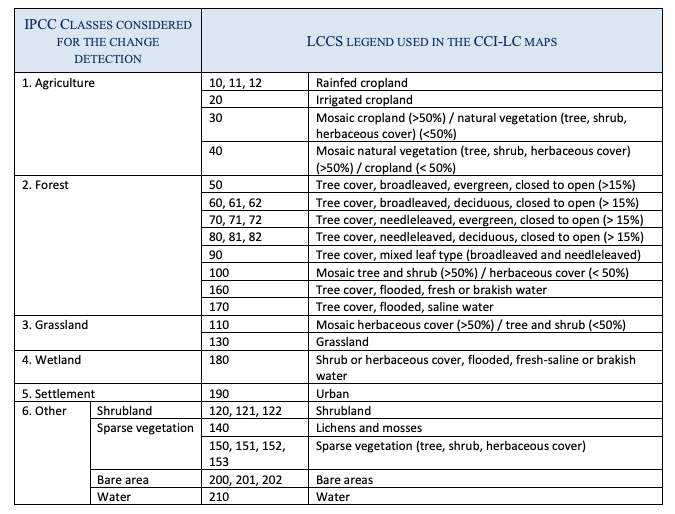

# Data Preparation

In [7]:
import os
import rasterio as rs
from rasterio.mask import mask
from rasterio.merge import merge
from rasterio.plot import show, show_hist, adjust_band
from rasterio.enums import Resampling
from rasterio import Affine, MemoryFile
from rasterio.windows import Window

import numpy as np 
import numpy.ma as ma 
import seaborn as sns
import matplotlib.pyplot as plt
import pyproj
import geopandas as gpd 
import shapely
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
import pandas as pd
import fiona
from contextlib import contextmanager  
from skimage.transform import resize
import math
import urllib.request
import osgeo
from osgeo import gdal
from osgeo import gdalconst
import glob
from copy import copy

%matplotlib inline

In [2]:
rs.__version__

'1.1.5'

In [3]:
gpd.__version__

'0.9.0'

## Shapefile to Geojson

In [17]:
def shp_to_gjson(shapefile, country):
    new_shp = gpd.read_file(f'{country}/shapefile/{shapefile}')
    new_shp.to_file(f'{country}/{country}_adminboundaries.geojson', driver='GeoJSON')
    print(f'crs: {new_shp.crs}')
    print(f'There are {len(new_shp)} admins in {country}')
    print(f'There are {new_shp.NAME_1.duplicated().sum()} duplicated admin names.')
    print('Confirm engtype column exists:')
    print(new_shp.ENGTYPE_1.value_counts())
    counter = 0
    for idx, row in new_shp.iterrows():
        counter += 1 if type(row.geometry) == MultiPolygon else 0
    print(f'Shapefile contains {counter} multipolygons')
    return new_shp.head()
    

In [12]:
shp_to_gjson('gadm36_CRI_1.shp', 'Costa Rica')

crs: epsg:4326
There are 7 admins in Costa Rica
There are 0 duplicated admin names.
Confirm engtype column exists:
Province    7
Name: ENGTYPE_1, dtype: int64
Shapefile contains 3 multipolygons


,GID_0,NAME_0,GID_1,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,geometry
0,CRI,Costa Rica,CRI.1_1,Alajuela,None,None,Provincia,Province,None,CR.AL,"POLYGON ((-84.46262 9.92246, -84.47685 9.91337..."
1,CRI,Costa Rica,CRI.2_1,Cartago,None,None,Provincia,Province,None,CR.CA,"POLYGON ((-83.81220 10.08073, -83.78162 10.063..."
2,CRI,Costa Rica,CRI.3_1,Guanacaste,None,None,Provincia,Province,None,CR.GU,"MULTIPOLYGON (((-85.51458 9.85958, -85.51458 9..."
3,CRI,Costa Rica,CRI.4_1,Heredia,None,None,Provincia,Province,None,CR.HE,"POLYGON ((-84.17006 9.96487, -84.17677 9.96769..."
4,CRI,Costa Rica,CRI.5_1,Limón,Puerto Lim¢n,None,Provincia,Province,None,CR.LI,"MULTIPOLYGON (((-82.61597 9.63208, -82.61597 9..."


In [2]:
cr = gpd.read_file('Costa Rica/Costa Rica_adminboundaries.geojson')
cr

,GID_0,NAME_0,GID_1,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,geometry
0,CRI,Costa Rica,CRI.1_1,Alajuela,None,None,Provincia,Province,None,CR.AL,"POLYGON ((-84.46262 9.92246, -84.47685 9.91337..."
1,CRI,Costa Rica,CRI.2_1,Cartago,None,None,Provincia,Province,None,CR.CA,"POLYGON ((-83.81220 10.08073, -83.78162 10.063..."
2,CRI,Costa Rica,CRI.3_1,Guanacaste,None,None,Provincia,Province,None,CR.GU,"MULTIPOLYGON (((-85.51458 9.85958, -85.51458 9..."
3,CRI,Costa Rica,CRI.4_1,Heredia,None,None,Provincia,Province,None,CR.HE,"POLYGON ((-84.17006 9.96487, -84.17677 9.96769..."
4,CRI,Costa Rica,CRI.5_1,Limón,Puerto Lim¢n,None,Provincia,Province,None,CR.LI,"MULTIPOLYGON (((-82.61597 9.63208, -82.61597 9..."
5,CRI,Costa Rica,CRI.6_1,Puntarenas,None,None,Provincia,Province,None,CR.PU,"MULTIPOLYGON (((-87.04792 5.55681, -87.04792 5..."
6,CRI,Costa Rica,CRI.7_1,San José,None,None,Provincia,Province,None,CR.SJ,"POLYGON ((-83.42517 9.36913, -83.43913 9.35049..."


In [10]:
cr[5:6].geometry.explode

<bound method GeoSeries.explode of 5    MULTIPOLYGON (((-87.04792 5.55681, -87.04792 5...
Name: geometry, dtype: geometry>

In [97]:
shp_to_gjson('gadm36_SLV_1.shp', 'El Salvador')

There are 14 admins in El Salvador
There are 0 duplicated admin names.
Confirm engtype column exists:
Department    14
Name: ENGTYPE_1, dtype: int64
Shapefile contains 3 multipolygons


,GID_0,NAME_0,GID_1,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,geometry
0,SLV,El Salvador,SLV.1_1,Ahuachapán,None,None,Departamento,Department,None,SV.AH,"POLYGON ((-89.81228 13.69891, -89.81432 13.690..."
1,SLV,El Salvador,SLV.2_1,Cabañas,None,None,Departamento,Department,None,SV.CA,"POLYGON ((-88.52493 13.73833, -88.52551 13.738..."
2,SLV,El Salvador,SLV.3_1,Chalatenango,None,None,Departamento,Department,None,SV.CH,"POLYGON ((-88.81071 13.95726, -88.81123 13.958..."
3,SLV,El Salvador,SLV.4_1,Cuscatlán,None,None,Departamento,Department,None,SV.CU,"POLYGON ((-88.95312 13.63865, -88.95364 13.638..."
4,SLV,El Salvador,SLV.5_1,La Libertad,None,None,Departamento,Department,None,SV.LI,"POLYGON ((-89.48122 13.49681, -89.48292 13.496..."


In [98]:
shp_to_gjson('gadm36_GTM_1.shp', 'Guatemala')

There are 22 admins in Guatemala
There are 0 duplicated admin names.
Confirm engtype column exists:
Department    22
Name: ENGTYPE_1, dtype: int64
Shapefile contains 3 multipolygons


,GID_0,NAME_0,GID_1,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,geometry
0,GTM,Guatemala,GTM.1_1,Alta Verapaz,None,None,Departamento,Department,None,GT.AV,"POLYGON ((-89.89300 15.14033, -89.91990 15.140..."
1,GTM,Guatemala,GTM.2_1,Baja Verapaz,None,None,Departamento,Department,None,GT.BV,"POLYGON ((-90.61563 14.87760, -90.61903 14.881..."
2,GTM,Guatemala,GTM.3_1,Chimaltenango,None,None,Departamento,Department,None,GT.CM,"POLYGON ((-90.82304 14.55669, -90.83588 14.560..."
3,GTM,Guatemala,GTM.4_1,Chiquimula,None,None,Departamento,Department,None,GT.CQ,"POLYGON ((-89.35089 14.42135, -89.35301 14.419..."
4,GTM,Guatemala,GTM.5_1,El Progreso,Guastatoya,None,Departamento,Department,None,GT.PR,"POLYGON ((-90.20348 14.67583, -90.20409 14.682..."


In [99]:
shp_to_gjson('gadm36_PAN_1.shp', 'Panama')

There are 13 admins in Panama
There are 0 duplicated admin names.
Confirm engtype column exists:
Province                10
Indigenous Territory     3
Name: ENGTYPE_1, dtype: int64
Shapefile contains 12 multipolygons


,GID_0,NAME_0,GID_1,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,geometry
0,PAN,Panama,PAN.1_1,Bocas del Toro,None,None,Provincia,Province,None,PA.BC,"MULTIPOLYGON (((-82.00051 8.95708, -82.00543 8..."
1,PAN,Panama,PAN.2_1,Chiriquí,None,None,Provincia,Province,None,PA.CH,"MULTIPOLYGON (((-82.44569 7.87097, -82.44569 7..."
2,PAN,Panama,PAN.3_1,Coclé,None,None,Provincia,Province,None,PA.CC,"MULTIPOLYGON (((-80.10986 8.35514, -80.10986 8..."
3,PAN,Panama,PAN.4_1,Colón,None,None,Provincia,Province,None,PA.CL,"MULTIPOLYGON (((-79.80153 9.43236, -79.80153 9..."
4,PAN,Panama,PAN.5_1,Darién,None,None,Provincia,Province,None,PA.DR,"MULTIPOLYGON (((-78.04708 7.40708, -78.04708 7..."


In [100]:
shp_to_gjson('gadm36_NIC_1.shp', 'Nicaragua')

There are 18 admins in Nicaragua
There are 0 duplicated admin names.
Confirm engtype column exists:
Department           15
Autonomous Region     2
Water body            1
Name: ENGTYPE_1, dtype: int64
Shapefile contains 8 multipolygons


,GID_0,NAME_0,GID_1,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,geometry
0,NIC,Nicaragua,NIC.1_1,Atlántico Norte,Región Autónoma del Atlántico Norte,None,Región Autónoma,Autonomous Region,None,NI.AN,"MULTIPOLYGON (((-83.37847 13.03319, -83.37847 ..."
1,NIC,Nicaragua,NIC.2_1,Atlántico Sur,Región Autónoma del Atlántico Norte,None,Región Autónoma,Autonomous Region,None,NI.AS,"MULTIPOLYGON (((-83.70679 11.51208, -83.70680 ..."
2,NIC,Nicaragua,NIC.3_1,Boaco,None,None,Departamento,Department,None,NI.BO,"POLYGON ((-85.78603 12.09338, -85.78617 12.095..."
3,NIC,Nicaragua,NIC.4_1,Carazo,None,None,Departamento,Department,None,NI.CA,"POLYGON ((-86.11349 11.60480, -86.11584 11.601..."
4,NIC,Nicaragua,NIC.5_1,Chinandega,None,None,Departamento,Department,None,NI.CI,"MULTIPOLYGON (((-87.06800 12.39569, -87.06819 ..."


In [101]:
shp_to_gjson('gadm36_BLZ_1.shp', 'Belize')

There are 6 admins in Belize
There are 0 duplicated admin names.
Confirm engtype column exists:
District    6
Name: ENGTYPE_1, dtype: int64
Shapefile contains 4 multipolygons


,GID_0,NAME_0,GID_1,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,geometry
0,BLZ,Belize,BLZ.1_1,Belize,None,None,District,District,None,BZ.BZ,"MULTIPOLYGON (((-88.27402 17.55458, -88.27402 ..."
1,BLZ,Belize,BLZ.2_1,Cayo,None,None,District,District,None,BZ.CY,"POLYGON ((-89.18222 16.51148, -89.17876 16.511..."
2,BLZ,Belize,BLZ.3_1,Corozal,None,None,District,District,None,BZ.CZ,"MULTIPOLYGON (((-88.12791 18.36486, -88.12764 ..."
3,BLZ,Belize,BLZ.4_1,Orange Walk,None,None,District,District,None,BZ.OW,"POLYGON ((-88.62050 17.48195, -88.73480 17.421..."
4,BLZ,Belize,BLZ.5_1,Stann Creek,None,None,District,District,None,BZ.SC,"MULTIPOLYGON (((-88.40264 16.52931, -88.41068 ..."


In [102]:
shp_to_gjson('gadm36_HND_1.shp', 'Honduras')

There are 18 admins in Honduras
There are 0 duplicated admin names.
Confirm engtype column exists:
Department    18
Name: ENGTYPE_1, dtype: int64
Shapefile contains 7 multipolygons


,GID_0,NAME_0,GID_1,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,geometry
0,HND,Honduras,HND.1_1,Atlántida,None,None,Departamento,Department,None,HN.AT,"MULTIPOLYGON (((-86.77486 15.80014, -86.77486 ..."
1,HND,Honduras,HND.2_1,Choluteca,None,None,Departamento,Department,None,HN.CH,"MULTIPOLYGON (((-87.42931 13.10403, -87.42931 ..."
2,HND,Honduras,HND.3_1,Colón,None,None,Departamento,Department,None,HN.CL,"MULTIPOLYGON (((-84.99772 15.84688, -84.99656 ..."
3,HND,Honduras,HND.4_1,Comayagua,None,None,Departamento,Department,None,HN.CM,"POLYGON ((-87.47681 14.19921, -87.47780 14.198..."
4,HND,Honduras,HND.5_1,Copán,None,None,Departamento,Department,None,HN.CP,"POLYGON ((-88.90347 14.51661, -88.90693 14.520..."


In [18]:
shp_to_gjson('gadm36_GMB_1.shp', 'Gambia')

crs: epsg:4326
There are 6 admins in Gambia
There are 0 duplicated admin names.
Confirm engtype column exists:
Division            5
Independent City    1
Name: ENGTYPE_1, dtype: int64
Shapefile contains 3 multipolygons


,GID_0,NAME_0,GID_1,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,geometry
0,GMB,Gambia,GMB.1_1,Banjul,None,None,Independent City,Independent City,None,GM.BJ,"MULTIPOLYGON (((-16.60569 13.43514, -16.60569 ..."
1,GMB,Gambia,GMB.2_1,Lower River,Central|South Bank,None,Division,Division,None,GM.LR,"POLYGON ((-15.80259 13.25908, -15.80983 13.258..."
2,GMB,Gambia,GMB.3_1,Maccarthy Island,Central River|Jangjangbureh|Janjanbureh|Janjan...,None,Division,Division,None,GM.MC,"POLYGON ((-14.74322 13.38864, -14.74783 13.394..."
3,GMB,Gambia,GMB.4_1,North Bank,None,None,Division,Division,None,GM.NB,"MULTIPOLYGON (((-16.50931 13.36375, -16.50931 ..."
4,GMB,Gambia,GMB.5_1,Upper River,None,None,Division,Division,None,GM.UR,"POLYGON ((-14.34783 13.22773, -14.34812 13.228..."


## Create Hansen Files

In [51]:
def create_hansen_tif(country):
    '''
    Identifies the latitude and longitude coordinates for a country 
    to download Hansen tree cover and tree cover loss tif files. 
    Returns combined tifs as one file in the country's folder.
    
    Attributes
    ----------
    country : str
        a string indicating the country files to import
    
    '''
    
    shapefile = gpd.read_file(f'{country}/{country}_adminboundaries.geojson')
    
    # identify min/max bounds for the country
    bounds = shapefile.geometry.bounds
    min_x = bounds.minx.min() 
    min_y = bounds.miny.min()
    max_x = bounds.maxx.max()
    max_y = bounds.maxy.max()

    # identify the lowest and highest 10 lat/lon increments for the country
    # index on top left corner
    lower_x = math.floor(min_x / 10) * 10 
    lower_y = math.ceil(min_y / 10) * 10 
    upper_x = math.ceil(max_x / 10) * 10 
    upper_y = math.ceil(max_y / 10) * 10
    #print(f'Rounded coords for {country}: ({lower_x}, {lower_y}, {upper_x}, {upper_y})')
    
    # negative values for W and S
    # postitive values for E and N
    lon = 'N' if lower_y > 0 else 'S'
    lat = 'E' if lower_x > 0 else 'W'
    print(f'{country} has lon {lon} and lat {lat}.')

    # create a list of tif file names for the country
    tree_cover_files = []
    loss_files = []
    
    for x_grid in range(lower_x, upper_x, 10):
        for y_grid in range(lower_y, upper_y + 10, 10):
            
            cover_tif = (f'hansen_treecover2010/treecover2010_' \
                         f'{str(y_grid).zfill(2)}{lon}_{str(np.absolute(x_grid)).zfill(3)}{lat}.tif')
            
            loss_tif = (f'hansen_lossyear2020/Hansen_GFC-2020-v1.8_lossyear_' \
                        f'{str(y_grid).zfill(2)}{lon}_{str(np.absolute(x_grid)).zfill(3)}{lat}.tif')
            
            if not os.path.exists(cover_tif) or not os.path.exists(loss_tif):
                print(f'Either {cover_tif} or {loss_tif} does not exist.')
            
            tree_cover_files.append(cover_tif)
            loss_files.append(loss_tif)
    
    # remove duplicate file names
    tree_tifs = [x for x in tree_cover_files if os.path.exists(x)] 
    loss_tifs = [x for x in loss_files if os.path.exists(x)]
    
    # convert tree cover and loss tifs into a virtual raster tile    
    gdal.BuildVRT(f'{country}/{country}_hansen_treecover2010.vrt', tree_tifs)
    gdal.BuildVRT(f'{country}/{country}_hansen_loss2020.vrt', loss_tifs)

    # open vrts and convert to a single .tif
    # FLAG -- adding tfw=yes increased file size significantly
    translateoptions = gdal.TranslateOptions(format='Gtiff', 
                                              outputSRS='EPSG:4326',
                                              outputType=gdal.GDT_Byte,
                                              noData=255,
                                              creationOptions=['COMPRESS=LZW'],
                                              resampleAlg='nearest')
 
    source = gdal.Open(f'{country}/{country}_hansen_treecover2010.vrt')
    ds = gdal.Translate(f'{country}/{country}_hansen_treecover2010.tif', source, options=translateoptions)
    os.remove(f'{country}/{country}_hansen_treecover2010.vrt')
                      
    source = gdal.Open(f'{country}/{country}_hansen_loss2020.vrt')
    ds = gdal.Translate(f'{country}/{country}_hansen_loss2020.tif', source, options=translateoptions)
    os.remove(f'{country}/{country}_hansen_loss2020.vrt')
    
    return None

In [39]:
create_hansen_tif('Costa Rica')

Costa Rica has lon N and lat W.


In [52]:
create_hansen_tif('El Salvador')

El Salvador has lon N and lat W.


In [149]:
create_hansen_tif('Guatemala')

In [154]:
create_hansen_tif('Panama')

In [40]:
create_hansen_tif('Honduras')

In [40]:
create_hansen_tif('Belize')

Belize has lon N and lat W.


In [45]:
create_hansen_tif('Nicaragua')

In [53]:
def remove_loss(country):
    '''
    Takes in a country name to import hansen tree cover loss tifs. Updates tree cover 
    to 0 if loss was detected between 2011-2020. Returns updated tif in the country's folder.
    
    Attributes
    ----------
    country : str
        a string indicating the country files to import
      '''
    
    hansen_cover = rs.open(f'{country}/{country}_hansen_treecover2010.tif').read(1) 
    hansen_loss = rs.open(f'{country}/{country}_hansen_loss2020.tif').read(1)
    
    # If there was loss between 2011-2020 (values between 11-20, make then 0 in tree cover
    hansen_cover_new = np.where((hansen_loss >= 11) & (hansen_loss <= 20), 0, hansen_cover)
    # logical and isn't working
    # hansen_cover[np.logical_and(hansen_loss >= 11, hansen_loss <= 20)] = 0
    
    # check bin counts after loss removed
    print(f'{(np.sum(hansen_cover > 0)) - (np.sum(hansen_cover_new > 0))} pixels converted to loss.')
    
    # save updated raster
    out_meta = rs.open(f'{country}/{country}_hansen_treecover2010.tif').meta
    out_meta.update({'driver': 'GTiff',    
                     'dtype': 'uint8',
                     'height': hansen_cover_new.shape[0],
                     'width': hansen_cover_new.shape[1],
                     'count': 1,
                     'compress':'lzw'})
    outpath = f'{country}/{country}_hansen_treecover2010_wloss.tif'
    with rs.open(outpath, 'w', **out_meta) as dest:
            dest.write(hansen_cover_new, 1) 
            # FLAG -- why 1 is needed here? rasterio is expecting data in (bands, rows, cols) order?
    
    # remove original hansen tree cover files
    os.remove(f'{country}/{country}_hansen_treecover2010.tif')
    os.remove(f'{country}/{country}_hansen_loss2020.tif')
    
    return None

In [42]:
# 38,050,442 pixels converted to loss.
remove_loss('Costa Rica')

38050442 pixels converted to loss.


In [54]:
# 59,400,753 pixels converted to loss.
remove_loss('El Salvador')

59400753 pixels converted to loss.


In [150]:
# will be the same Hansen processing area as El Salvador 
remove_loss('Guatemala')

59400753 pixels converted to loss.


In [156]:
remove_loss('Panama')

38598272 pixels converted to loss.


In [42]:
remove_loss('Honduras')

35697769 pixels converted to loss.


In [43]:
# 35,697,769
remove_loss('Belize')

35697769 pixels converted to loss.


In [47]:
remove_loss('Nicaragua')

35697769 pixels converted to loss.


## Pad TOF Raster

In [55]:
def pad_tof_raster(country):
    
    '''
    Increase the raster extent to match the boundas of a country's shapefile
    and fill with no data value.
    
    Attributes
    ----------
    country : str
        a string indicating the country files to import
    shapefile : .geojson or .shp file
        shapefile containing subnational administrative boundaries level 0-2
    '''
    
    shapefile = gpd.read_file(f'{country}/{country}_adminboundaries.geojson')

    # identify min/max bounds for the country
    bounds = shapefile.geometry.bounds
    min_x = bounds.minx.min() 
    min_y = bounds.miny.min()
    max_x = bounds.maxx.max()
    max_y = bounds.maxy.max()
    print(f'Original bounds: ({min_x}, {min_y}, {max_x}, {max_y})')
    
    # round to the nearest .1 lat/lon
    lower_x = math.floor(min_x * 10) / 10 
    lower_y = math.floor(min_y * 10) / 10 
    upper_x = math.ceil(max_x * 10) / 10
    upper_y = math.ceil(max_y * 10) / 10
    print(f'Padding bounds: ({lower_x}, {lower_y}, {upper_x}, {upper_y}')
          
    # create tif with new output bounds, filled with no data value
    warp_options = gdal.WarpOptions(format='Gtiff', 
                                    dstSRS='EPSG:4326',
                                    dstNodata=255,
                                    outputBounds=[lower_x, lower_y, upper_x, upper_y],
                                    resampleAlg='near',
                                    outputType=osgeo.gdalconst.GDT_Byte,
                                    creationOptions=['TFW=YES', 'COMPRESS=LZW'])
          
    ds = gdal.Warp(f'{country}/{country}_tof_padded.tif', 
                   f'{country}/{country}_tof.tif',      
                   options=warp_options)                  
    
    return None

In [51]:
pad_tof_raster('Costa Rica')

Original bounds: (-87.09486389, 5.49902678, -82.55322266, 11.21691799)
Padding bounds: (-87.1, 5.4, -82.5, 11.3)


In [56]:
pad_tof_raster('El Salvador')

Original bounds: (-90.12486267, 13.15264034, -87.68374634, 14.45055103)
Padding bounds: (-90.2, 13.1, -87.6, 14.5


In [158]:
pad_tof_raster('Guatemala')

In [4]:
pad_tof_raster('Panama')

Original bounds: (-83.05017853, 7.2023592, -77.17324066, 9.6473608)
Padding bounds: (-83.1, 7.2, -77.1, 9.7


In [27]:
pad_tof_raster('Honduras')

Original bounds: (-89.35079193, 12.98453999, -82.40569305, 17.41847229)
Padding bounds: (-89.4, 12.9, -82.4, 17.5


In [48]:
pad_tof_raster('Belize')

Original bounds: (-89.22417449951172, 15.892658233642578, -87.48596954345697, 18.497289657592887)
Padding bounds: (-89.3, 15.8, -87.4, 18.5


In [49]:
pad_tof_raster('Nicaragua')

Original bounds: (-87.69097137, 10.70754242, -81.99986267, 15.02591038)
Padding bounds: (-87.7, 10.7, -81.9, 15.1


## Clip Rasters by Admin Boundary

In [57]:
def create_clippings(country):
    '''
    Takes in a country name to import tof/hansen rasters and masks out administrative 
    boundaries based on the shapefile. Saves exploded shapefile as a geojson with polygons 
    split/numbered for each admin boundary. Returns clipped rasters as individual 
    files in the country's "clipped_rasters" folder. Deletes the original Hansen file. 
    
    Attributes
    ----------
    country : str
        a string indicating the country files to import        
    '''
    
    if not os.path.exists(f'{country}/clipped_rasters/hansen'):
        os.makedirs(f'{country}/clipped_rasters/hansen')
    
    if not os.path.exists(f'{country}/clipped_rasters/tof'):
        os.makedirs(f'{country}/clipped_rasters/tof')
    
    if not os.path.exists(f'{country}/clipped_rasters/esa'):
        os.makedirs(f'{country}/clipped_rasters/esa')
    
    shapefile = gpd.read_file(f'{country}/{country}_adminboundaries.geojson')
    tof_raster = rs.open(f'{country}/{country}_tof_padded.tif') 
    hansen_raster = rs.open(f'{country}/{country}_hansen_treecover2010_wloss.tif')
    esa_raster = rs.open('ESACCI-LC-L4-LCCS-Map-300m-P1Y-2015-v2.0.7.tif')
    
    # preprocess shapefile from multipolygon to single
    counter = 0
    for idx, row in shapefile.iterrows():
        counter += 1 if type(row.geometry) == MultiPolygon else 0

    if counter > 0:
        shapefile = shapefile.explode()

    # add integer to admin name if duplicated
    shapefile.NAME_1 = np.where(shapefile.NAME_1.duplicated(keep=False), 
                                 shapefile.NAME_1 + shapefile.groupby('NAME_1').cumcount().add(1).astype(str),
                                 shapefile.NAME_1)
    
    # reset index
    shapefile = shapefile.reset_index()
    shapefile.drop(columns=['level_0', 'level_1'], inplace=True)
    
    shapefile.to_file(f'{country}/{country}_adminboundaries_exp.geojson', driver='GeoJSON')
    
    def mask_raster(polygon, admin, raster, folder):
        out_img, out_transform = mask(dataset=raster, shapes=[polygon], crop=True, nodata=0)
        out_meta = raster.meta
        out_meta.update({'driver': 'GTiff',    
                         'dtype': 'uint8',
                         'height': out_img.shape[1],
                         'width': out_img.shape[2],
                         'transform': out_transform})
        outpath = f'{country}/clipped_rasters/{folder}/{admin}.tif'
        with rs.open(outpath, 'w', **out_meta) as dest:
            dest.write(out_img)
        return None
    
    for polygon, admin in zip(shapefile.geometry, shapefile.NAME_1):
        mask_raster(polygon, admin, tof_raster, 'tof')
        mask_raster(polygon, admin, hansen_raster, 'hansen')
        mask_raster(polygon, admin, esa_raster, 'esa')
        
    
    # delete original Hansen once clippings created
    os.remove(f'{country}/{country}_hansen_treecover2010_wloss.tif')
    
    return f"{country}'s rasters clipped and saved."

In [58]:
create_clippings('El Salvador')

"El Salvador's rasters clipped and saved."

In [23]:
create_clippings('Costa Rica')

In [8]:
create_clippings('Guatemala')

"Guatemala's rasters clipped and saved."

In [9]:
create_clippings('Panama')

"Panama's rasters clipped and saved."

In [10]:
create_clippings('Honduras')

"Honduras's rasters clipped and saved."

In [11]:
create_clippings('Belize')

"Belize's rasters clipped and saved."

In [51]:
create_clippings('Nicaragua')

"Nicaragua's rasters clipped and saved."

## Resample to Match Resolution

In [37]:
def match_extent_and_res(source, reference, out_filename, tof=False, esa=False):

    '''
    Matches the projection, bounding box, and dimensions of source to reference
    '''
    
    # set up the source file 
    src = gdal.Open(source, gdalconst.GA_ReadOnly)
    src_proj = src.GetProjection()
    src_geotrans = src.GetGeoTransform()

    # set up the reference file (esa)
    ref_ds = gdal.Open(reference, gdalconst.GA_ReadOnly)
    ref_proj = ref_ds.GetProjection()
    ref_geotrans = ref_ds.GetGeoTransform()
    
    # create height/width for the interpolation (ref dataset except for tof)
    width = ref_ds.RasterXSize if not tof else src.RasterXSize
    height = ref_ds.RasterYSize if not tof else src.RasterYSize

    out = gdal.GetDriverByName('GTiff').Create(out_filename, width, height, 1, gdalconst.GDT_Byte)
    
    # do not adjust the bounds for esa, use source (esa)
    if esa:
        ref_proj = src_proj
        ref_geotrans = src.GetGeoTransform()
    
    # set geotrans and proj for the out file
    out.SetGeoTransform(ref_geotrans)
    out.SetProjection(ref_proj)

    interpolation = gdalconst.GRA_NearestNeighbour
    gdal.ReprojectImage(src, out, src_proj, ref_proj, interpolation)

    return None

In [38]:
def apply_extent_res(country):
    
    '''
    Applies match_raster_extent_and_res() to all admin files
    for a country.
    '''
    
    if not os.path.exists(f'{country}/resampled_rasters/hansen'):
        os.makedirs(f'{country}/resampled_rasters/hansen')
    
    if not os.path.exists(f'{country}/resampled_rasters/tof'):
        os.makedirs(f'{country}/resampled_rasters/tof')
    
    if not os.path.exists(f'{country}/resampled_rasters/esa'):
        os.makedirs(f'{country}/resampled_rasters/esa')
    
    # import new shapefile containing only polygons
    shapefile = gpd.read_file(f'{country}/{country}_adminboundaries_exp.geojson')
    admin_boundaries = list(shapefile.NAME_1)
    
    for admin in admin_boundaries:
        
        # apply to esa
        match_extent_and_res(f'{country}/clipped_rasters/esa/{admin}.tif', # source
                             f'{country}/clipped_rasters/tof/{admin}.tif', # reference
                             f'{country}/resampled_rasters/esa/{admin}.tif', # outpath
                             tof = False, # is this tof?
                             esa = True) # is this esa?
        
        # apply to tof
        match_extent_and_res(f'{country}/clipped_rasters/tof/{admin}.tif', 
                             f'{country}/resampled_rasters/esa/{admin}.tif', 
                             f'{country}/resampled_rasters/tof/{admin}.tif', 
                             tof = True, 
                             esa = False) 
        
        # apply to hansen
        match_extent_and_res(f'{country}/clipped_rasters/hansen/{admin}.tif', 
                             f'{country}/resampled_rasters/esa/{admin}.tif', 
                             f'{country}/resampled_rasters/hansen/{admin}.tif', 
                             tof = False, 
                             esa = False) 
        
    return None

In [39]:
apply_extent_res('El Salvador')

In [30]:
apply_extent_res('Belize')

In [16]:
hans_clip = rs.open(f'El Salvador/clipped_rasters/hansen/Ahuachapán.tif')
tof_clip = rs.open(f'El Salvador/clipped_rasters/tof/Ahuachapán.tif')
esa_clip = rs.open(f'El Salvador/clipped_rasters/esa/Ahuachapán.tif')
print(hans_clip.shape, esa_clip.shape, tof_clip.shape)

(1616, 1738) (147, 157) (4391, 4722)


In [17]:
hans_resamp = rs.open(f'El Salvador/resampled_rasters/hansen/Ahuachapán.tif')
tof_resamp = rs.open(f'El Salvador/resampled_rasters/tof/Ahuachapán.tif')
esa_resamp = rs.open(f'El Salvador/resampled_rasters/esa/Ahuachapán.tif')
print(hans_resamp.shape, esa_resamp.shape, tof_resamp.shape)

(4391, 4722) (4391, 4722) (4722, 4722)


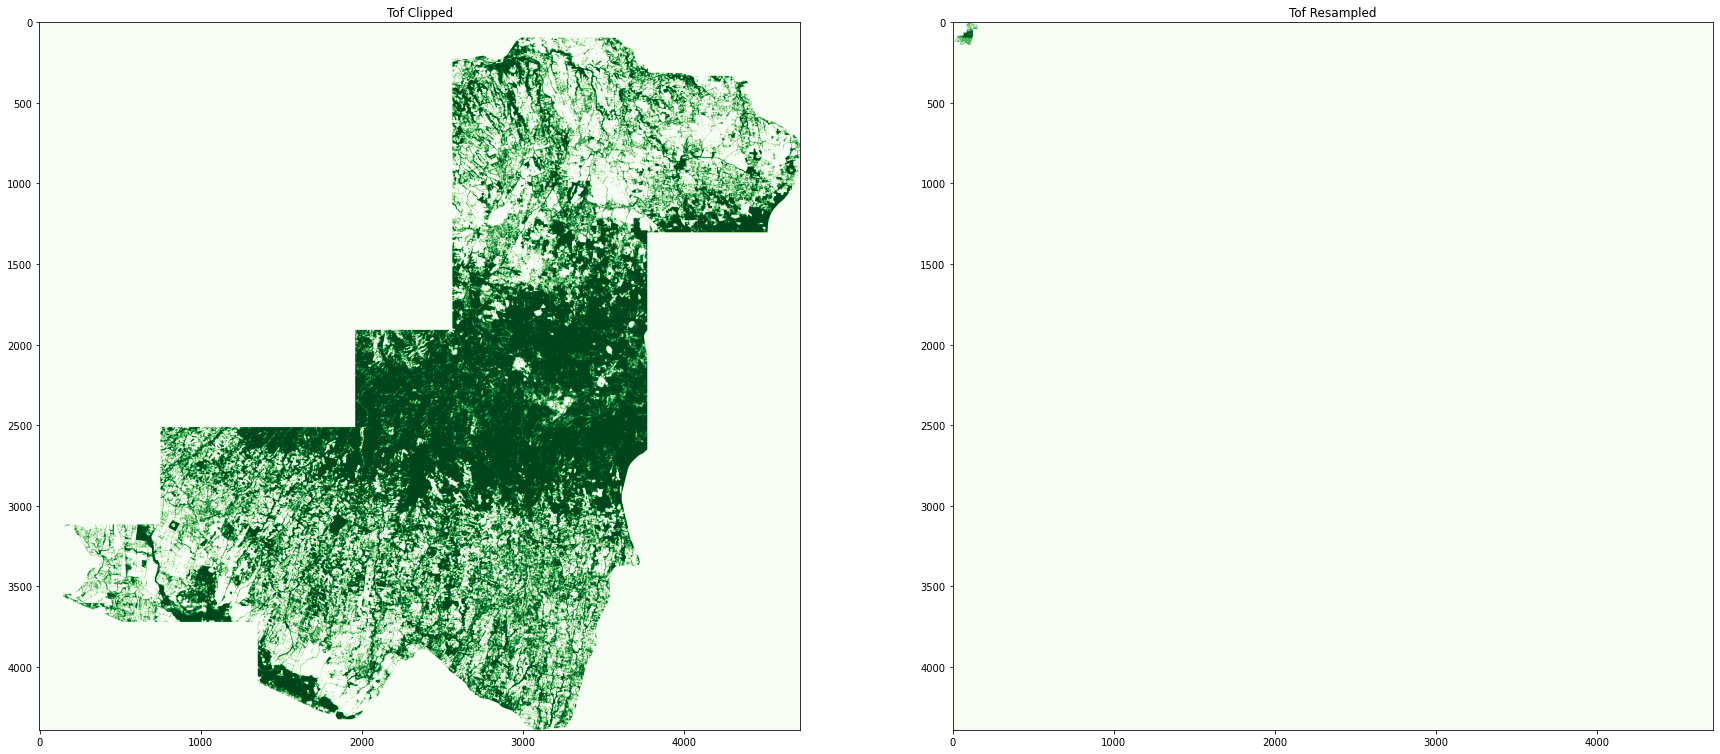

In [24]:
plt.figure(figsize=(30,20))

tof_clip = rs.open(f'El Salvador/clipped_rasters/tof/Ahuachapán.tif')
tof_resamp = rs.open(f'El Salvador/resampled_rasters/tof/Ahuachapán.tif')

plt.subplot(1,2,1)
plt.imshow(tof_clip.read(1), cmap='Greens', vmin=0, vmax=100)
plt.title('Tof Clipped')

plt.subplot(1,2,2)
plt.imshow(tof_resamp.read(1), cmap='Greens', vmin=0, vmax=100)
plt.title('Tof Resampled')


plt.tight_layout;

## Merge Admin Polygons

In [31]:
def merge_polygons(country, data):
    '''
    Takes in a country to iterate through the resampled rasters and identify
    which admin boundaries are composed of multipolygons. Combines individual files
    as one for the admin, removes individual files.
    '''
    shapefile = gpd.read_file(f'{country}/{country}_adminboundaries_exp.geojson')
    admin_boundaries_all = list(shapefile.NAME_1)
    
    # identify which admins have multiple files (integers in filename) and remove digits
    no_ints = []
    for admin in admin_boundaries_all:
        
        # if any characters are digits, remove them and ad admin to list
        if any(char.isdigit() for char in admin):
            clean_admin = ''.join([char for char in admin if not char.isdigit()])
            no_ints.append(clean_admin)

    no_ints = list(set(no_ints))
    print(f'Admins that will be merged: {no_ints}')

    for admin_2 in no_ints:

        # gather list of files for that admin (ex: Puntarenas1.tif, Puntarenas2.tif, Puntarenas3.tif)
        files_to_merge = [] # items need to be in dataset reader mode
        files_to_delete = [] # items are just string of the file name
        
        for path in glob.glob(f'{country}/resampled_rasters/{data}/{admin_2}?.tif'):
            filename = os.path.basename(path) 
            files_to_delete.append(filename)
            src = rs.open(f'{country}/resampled_rasters/{data}/{filename}')
            files_to_merge.append(src)
        
        # capture double digits
        for path in glob.glob(f'{country}/resampled_rasters/{data}/{admin_2}??.tif'):
            filename = os.path.basename(path) 
            files_to_delete.append(filename)
            src = rs.open(f'{country}/resampled_rasters/{data}/{filename}')
            files_to_merge.append(src)
            
        # capture triple digits
        for path in glob.glob(f'{country}/resampled_rasters/{data}/{admin_2}???.tif'):
            filename = os.path.basename(path) 
            files_to_delete.append(filename)
            src = rs.open(f'{country}/resampled_rasters/{data}/{filename}')
            files_to_merge.append(src)
            
        if len(files_to_merge) < 1:
            print(f'No files to merge in {data}.')
            
        mosaic, out_transform = merge(files_to_merge)

        outpath = f'{country}/resampled_rasters/{data}/{admin_2}.tif'
        out_meta = src.meta.copy()
        out_meta.update({'driver': "GTiff",
                         'dtype': 'uint8',
                         'height': mosaic.shape[1],
                         'width': mosaic.shape[2],
                         'transform': out_transform})

        with rs.open(outpath, "w", **out_meta) as dest:
            dest.write(mosaic)

        # delete the old separated tifs
        for file in files_to_delete:
            os.remove(f'{country}/resampled_rasters/{data}/{file}')

    return None

In [32]:
merge_polygons('El Salvador', 'tof')
merge_polygons('El Salvador', 'hansen')
merge_polygons('El Salvador', 'esa')

Admins that will be merged: ['La Paz', 'La Unión', 'Usulután']
Admins that will be merged: ['La Paz', 'La Unión', 'Usulután']
Admins that will be merged: ['La Paz', 'La Unión', 'Usulután']


In [26]:
merge_polygons('Costa Rica', 'tof')
merge_polygons('Costa Rica', 'hansen')
merge_polygons('Costa Rica', 'esa')

Admins that will be merged: ['Guanacaste', 'Limón', 'Puntarenas']
Admins that will be merged: ['Guanacaste', 'Limón', 'Puntarenas']
Admins that will be merged: ['Guanacaste', 'Limón', 'Puntarenas']


In [14]:
merge_polygons('Guatemala', 'tof')
merge_polygons('Guatemala', 'hansen')
merge_polygons('Guatemala', 'esa')

Admins that will be merged: ['Izabal', 'Jutiapa', 'Escuintla']
Admins that will be merged: ['Izabal', 'Jutiapa', 'Escuintla']
Admins that will be merged: ['Izabal', 'Jutiapa', 'Escuintla']


In [27]:
merge_polygons('Panama', 'tof')
merge_polygons('Panama', 'hansen')
merge_polygons('Panama', 'esa')

Admins that will be merged: ['Chiriquí', 'Emberá', 'Ngöbe Buglé', 'Darién', 'Kuna Yala', 'Colón', 'Bocas del Toro', 'Panamá', 'Panamá Oeste', 'Coclé', 'Veraguas', 'Los Santos']
Admins that will be merged: ['Chiriquí', 'Emberá', 'Ngöbe Buglé', 'Darién', 'Kuna Yala', 'Colón', 'Bocas del Toro', 'Panamá', 'Panamá Oeste', 'Coclé', 'Veraguas', 'Los Santos']
Admins that will be merged: ['Chiriquí', 'Emberá', 'Ngöbe Buglé', 'Darién', 'Kuna Yala', 'Colón', 'Bocas del Toro', 'Panamá', 'Panamá Oeste', 'Coclé', 'Veraguas', 'Los Santos']


In [62]:
merge_polygons('Honduras', 'tof')
merge_polygons('Honduras', 'hansen')
merge_polygons('Honduras', 'esa')

Admins that will be merged: ['Choluteca', 'Atlántida', 'Cortés', 'Valle', 'Islas de la Bahía', 'Gracias a Dios', 'Colón']
Admins that will be merged: ['Choluteca', 'Atlántida', 'Cortés', 'Valle', 'Islas de la Bahía', 'Gracias a Dios', 'Colón']
Admins that will be merged: ['Choluteca', 'Atlántida', 'Cortés', 'Valle', 'Islas de la Bahía', 'Gracias a Dios', 'Colón']


In [33]:
merge_polygons('Belize', 'tof')
merge_polygons('Belize', 'hansen')
merge_polygons('Belize', 'esa')

Admins that will be merged: ['Stann Creek', 'Corozal', 'Belize', 'Toledo']
Admins that will be merged: ['Stann Creek', 'Corozal', 'Belize', 'Toledo']
Admins that will be merged: ['Stann Creek', 'Corozal', 'Belize', 'Toledo']


In [55]:
merge_polygons('Nicaragua', 'tof')
merge_polygons('Nicaragua', 'hansen')
merge_polygons('Nicaragua', 'esa')

Admins that will be merged: ['Chontales', 'Rivas', 'Atlántico Norte', 'Río San Juan', 'León', 'Chinandega', 'Atlántico Sur', 'Granada']
Admins that will be merged: ['Chontales', 'Rivas', 'Atlántico Norte', 'Río San Juan', 'León', 'Chinandega', 'Atlántico Sur', 'Granada']
Admins that will be merged: ['Chontales', 'Rivas', 'Atlántico Norte', 'Río San Juan', 'León', 'Chinandega', 'Atlántico Sur', 'Granada']


# Calculate Statistics

This section is focused on tree cover statistics by administrative district and by ESA/IPCC land cover category. Tree cover estimates are compared between the TOF and Hansen data.  

A distinction is made between reporting on contiguous and non-contiguous hectares. 
- A non-contiguous hectare refers to the total extent of trees, reported in hectares, of 10x10m pixels where the pixel is included if it has >x% cover. Non-contiguous does not differentiate between parcels, so it does not distinguish between forest or scattered tree cover in a single parcel, rather sums tree cover across all parcels.
- A contiguous hectare refers to the total number of hectares of tree cover >10%.

**calculate_stats_tof_hansen(country)**  
In order to derive statistics from the Hansen and TOF geotiffs for each admin district, the data is reshaped into a 4-dimensional 10x10 grid. The function calculates the mean tree cover for the entire district as well as the mean tree cover per hectare. The means are binned into 20% intervals representing the number of hectares of tree cover that fall between....? Compares the mean tree cover and number of hectares BETWEEN thresholds for tof and hansen per admin boundary. So 0 - 20%, 20 - 40%, etc.  
        
**thresholds_by_lcc(country)**  
Tree cover for Hansen and TOF per IPCC class: compare the number of hectares per IPCC class ABOVE and BETWEEN thresholds. 

- Hansen data often times has a huge overestimation of canopy cover at 10% threshold. Most people use either 30% or 50% for the Hansen data.
- Looking at tree cover per IPCC class would help us understand open vs. closed canopy forests.

## TOF vs Hansen

In [22]:
def reshape_to_4d(raster):
    
    '''
    Takes in a raster, identifies the dimensions and them down to the nearest 10th.
    Returns a reshaped 10x10 grid array. 
    
    Attributes
    ----------
    raster : str
        tree cover raster file to be reshaped
    '''
    
    def round_down(num, divisor):
         return num - (num%divisor)
   
    # round down rows and cols to nearest 10th
    rows, cols = round_down(raster.shape[0], 10), round_down(raster.shape[1], 10)
    
    # clip according to rounded numbers and reshape
    rounded = raster[:rows, :cols]
    reshaped = np.reshape(rounded, (rounded.shape[0] // 10, 10, rounded.shape[1] // 10, 10))
        
    return reshaped


In [23]:
def calculate_stats_tof_hansen(country):
    
    '''
    Takes in a country to import appropriate tof/hansen rasters and calculates mean tree cover 
    per admin and the total number of hectares that fall within 5 20% thresholds (0-20%, 20-40%, 
    40-60%, 60-80%). Returns a pandas dataframe with statistics saved as a csv file in the country's
    stats folder.
    
    Attributes
    ----------
    country : str
        a string indicating the country files to import
    '''
    
    if not os.path.exists(f'{country}/stats'):
        os.makedirs(f'{country}/stats')
    
    tree_cover = pd.DataFrame(columns=['admin', 
                                       'tof_mean_tc',
                                       'hans_mean_tc',
                                       'tof_0_20',
                                       'tof_20_40',
                                       'tof_40_60',
                                       'tof_60_80',
                                       'tof_80_100',
                                       'hans_0_20',
                                       'hans_20_40',
                                       'hans_40_60',
                                       'hans_60_80',
                                       'hans_80_100'])
    
    for file in [f for f in os.listdir(f'{country}/resampled_rasters/tof') if f != '.ipynb_checkpoints']:
        
        tof = rs.open(f'{country}/resampled_rasters/tof/{file}').read(1)
        hansen = rs.open(f'{country}/resampled_rasters/hansen/{file}').read(1)

        # reshape to 10x10 grid - ex: (88, 10, 63, 10)
        tof_reshaped = reshape_to_4d(tof)
        hansen_reshaped = reshape_to_4d(hansen)
         
        # calculate mean tree cover for admin boundary
        tof_mean = round(np.mean(tof_reshaped), 3)   
        hansen_mean = round(np.mean(hansen_reshaped), 3)   

        # calculate mean tree cover for each hectare
        tof_mean_per_ha = np.mean(tof_reshaped, axis=(1,3)) 
        hansen_mean_per_ha = np.mean(hansen_reshaped, axis=(1,3)) 
        
        # calculate num of hectares with mean tree cover 0-20, 20-40, 40-60, 60-80, 80-100
        tof_0_20 = np.sum((tof_mean_per_ha >= 0) & (tof_mean_per_ha <= 19)) 
        tof_20_40 = np.sum((tof_mean_per_ha >= 20) & (tof_mean_per_ha <= 39)) 
        tof_40_60 = np.sum((tof_mean_per_ha >= 40) & (tof_mean_per_ha <= 59)) 
        tof_60_80 = np.sum((tof_mean_per_ha >= 60) & (tof_mean_per_ha <= 79)) 
        tof_80_100 = np.sum((tof_mean_per_ha >= 80) & (tof_mean_per_ha <= 100)) 
        
        hans_0_20 = np.sum((hansen_mean_per_ha >= 0) & (hansen_mean_per_ha <= 19)) 
        hans_20_40 = np.sum((hansen_mean_per_ha >= 20) & (hansen_mean_per_ha <= 39)) 
        hans_40_60 = np.sum((hansen_mean_per_ha >= 40) & (hansen_mean_per_ha <= 59)) 
        hans_60_80 = np.sum((hansen_mean_per_ha >= 60) & (hansen_mean_per_ha <= 79)) 
        hans_80_100 = np.sum((hansen_mean_per_ha >= 80) & (hansen_mean_per_ha <= 100)) 
        
        tree_cover = tree_cover.append({'admin': file[:-4], 
                                        'tof_mean_tc': tof_mean,
                                        'hans_mean_tc': hansen_mean,
                                        'tof_0_20': tof_0_20,
                                        'tof_20_40': tof_20_40,
                                        'tof_40_60': tof_40_60,
                                        'tof_60_80': tof_60_80,
                                        'tof_80_100': tof_80_100,
                                        'hans_0_20': hans_0_20,
                                        'hans_20_40': hans_20_40,
                                        'hans_40_60': hans_40_60,
                                        'hans_60_80': hans_60_80,
                                        'hans_80_100': hans_80_100}, ignore_index=True)
        # save to csv      
        tree_cover.to_csv(f'{country}/stats/{country}_statistics01.csv', index=False)
    
    return None

In [69]:
calculate_stats_tof_hansen('Costa Rica')

In [37]:
calculate_stats_tof_hansen('El Salvador')

In [12]:
calculate_stats_tof_hansen('Guatemala')

In [36]:
calculate_stats_tof_hansen('Honduras')

In [58]:
calculate_stats_tof_hansen('Panama')

In [56]:
calculate_stats_tof_hansen('Belize')

In [4]:
calculate_stats_tof_hansen('Nicaragua')

## Tree Cover per Land Cover Class

In [27]:
def thresholds_by_lcc(country):
    '''
    Takes in a country to import appropriate tof/hansen rasters. 
    For each ESA land cover class within each admin district, calculates the mean 
    tree cover and the total number of contiguous hectares of tree cover above 10% 
    thresholds. Then calculates the total hectares of tree cover within 5
    20% thresholds (0-20%, 20-40%, 40-60%, 60-80%). The land cover categories and numbers 
    are aggregated to display the same statistics per IPCC land cover class.
    
    Attributes
    ----------
    country : str
        a string indicating the country files to import

    '''
    
    # set up the dataframes
    ipcc_above = pd.DataFrame(columns=['admin', 
                                       'esa_id',
                                       'esa_class',
                                       'ipcc_class',
                                       'tof_mean_tc_lc',
                                       'hans_mean_tc_lc',
                                       'tof_10+','tof_20+','tof_30+','tof_40+',
                                       'tof_50+', 'tof_60+','tof_70+','tof_80+',
                                       'tof_90+','hans_10+','hans_20+','hans_30+', 
                                       'hans_40+','hans_50+', 'hans_60+','hans_70+',
                                       'hans_80+','hans_90+']) 
    
    
    ipcc_btw = pd.DataFrame(columns=['admin', 
                                     'esa_id',
                                     'esa_class',
                                     'ipcc_class',
                                     'tof_mean_tc_lc',
                                     'hans_mean_tc_lc',
                                     'tof_0_20','tof_20_40','tof_40_60','tof_60_80',
                                     'tof_80_100','hans_0_20','hans_20_40','hans_40_60',
                                     'hans_60_80','hans_80_100'])
    
    counter = 0
    folder_contents = [f for f in os.listdir(f'{country}/resampled_rasters/tof') if f != '.ipynb_checkpoints']
    
    for file in folder_contents:
        
        counter += 1
        
        # read in as an int
        tof = rs.open(f'{country}/resampled_rasters/tof/{file}').read(1)
        hans = rs.open(f'{country}/resampled_rasters/hansen/{file}').read(1)
        esa = rs.open(f'{country}/resampled_rasters/esa/{file}').read(1)
        
        # resize esa/hansen to have the same shape as tof and reshape for stats
        # skimage resize will convert it to a float, keep as byte for resize
        if esa.shape != tof.shape:
            esa = resize(esa, tof.shape, order=0, preserve_range=True)
        
        if hans.shape != tof.shape:
            hans = resize(hans, tof.shape, order=0, preserve_range=True)
        
        # ensure everything is a float32 for np.NaN
        tof = tof.astype(np.float32)
        hans = hans.astype(np.float32)
        esa = esa.astype(np.float32)
        
        # convert all numbers to their median value
        tof[tof < 90] += 4.5
        
        # identify the lccs for that admin district
        esa_classes = np.unique(esa)
        
        for cover in esa_classes:
            
            # change all values that are not equal to the lcc to NaN
            # replace all no data values with np.nan
            tof_class = tof.copy()
            tof_class[esa != cover] = np.nan 
            tof_class[tof_class == 255] = np.nan
            
            # check - count the number of non nan instances 
            print(f'For {cover} there are {np.count_nonzero(~np.isnan(tof_class))} non NaNs') 

            # reshape to a 10x10 grid to calculate stats
            # calc mean tree cover for the lcc (entire admin) and mean tree cover for the lcc per hectare
            # note that runtime warning: mean of empty slice indicates array has nothing but nan values
            tof_reshaped = reshape_to_4d(tof_class) 
            tof_class_mean = np.nanmean(tof_reshaped)
            tof_class_mean_per_ha = np.nanmean(tof_reshaped, axis=(1,3))
            
            # same for Hansen
            hans_class = hans.copy()
            hans_class[esa != cover] = np.nan
            
            # reshape and calculate stats
            hans_reshaped = reshape_to_4d(hans_class)
            hans_class_mean = np.nanmean(hans_reshaped)
            hans_class_mean_per_ha = np.nanmean(hans_reshaped, axis=(1,3))

            # calculate num of hectares above each threshold for the lcc
            tof_ha_over10 = np.sum(tof_class_mean_per_ha > 10.0) 
            tof_ha_over20 = np.sum(tof_class_mean_per_ha > 20.0) 
            tof_ha_over30 = np.sum(tof_class_mean_per_ha > 30.0) 
            tof_ha_over40 = np.sum(tof_class_mean_per_ha > 40.0) 
            tof_ha_over50 = np.sum(tof_class_mean_per_ha > 50.0)
            tof_ha_over60 = np.sum(tof_class_mean_per_ha > 60.0) 
            tof_ha_over70 = np.sum(tof_class_mean_per_ha > 70.0) 
            tof_ha_over80 = np.sum(tof_class_mean_per_ha > 80.0) 
            tof_ha_over90 = np.sum(tof_class_mean_per_ha > 90.0) 
            
            hans_ha_over10 = np.sum(hans_class_mean_per_ha > 10.0) 
            hans_ha_over20 = np.sum(hans_class_mean_per_ha > 20.0) 
            hans_ha_over30 = np.sum(hans_class_mean_per_ha > 30.0) 
            hans_ha_over40 = np.sum(hans_class_mean_per_ha > 40.0) 
            hans_ha_over50 = np.sum(hans_class_mean_per_ha > 50.0) 
            hans_ha_over60 = np.sum(hans_class_mean_per_ha > 60.0) 
            hans_ha_over70 = np.sum(hans_class_mean_per_ha > 70.0) 
            hans_ha_over80 = np.sum(hans_class_mean_per_ha > 80.0) 
            hans_ha_over90 = np.sum(hans_class_mean_per_ha > 90.0)           
            
            # calculate num of hectares between thresholds for the lcc
            tof_0_20 = np.sum((tof_class_mean_per_ha >= 0) & (tof_class_mean_per_ha <= 19)) 
            tof_20_40 = np.sum((tof_class_mean_per_ha >= 20) & (tof_class_mean_per_ha <= 39)) 
            tof_40_60 = np.sum((tof_class_mean_per_ha >= 40) & (tof_class_mean_per_ha <= 59)) 
            tof_60_80 = np.sum((tof_class_mean_per_ha >= 60) & (tof_class_mean_per_ha <= 79)) 
            tof_80_100 = np.sum((tof_class_mean_per_ha >= 80) & (tof_class_mean_per_ha <= 100)) 

            hans_0_20 = np.sum((hans_class_mean_per_ha >= 0) & (hans_class_mean_per_ha <= 19)) 
            hans_20_40 = np.sum((hans_class_mean_per_ha >= 20) & (hans_class_mean_per_ha <= 39)) 
            hans_40_60 = np.sum((hans_class_mean_per_ha >= 40) & (hans_class_mean_per_ha <= 59)) 
            hans_60_80 = np.sum((hans_class_mean_per_ha >= 60) & (hans_class_mean_per_ha <= 79)) 
            hans_80_100 = np.sum((hans_class_mean_per_ha >= 80) & (hans_class_mean_per_ha <= 100)) 
            
            
            ipcc_above = ipcc_above.append({'admin': file[:-4], 
                                            'esa_id': cover,
                                            'tof_mean_tc_lc': tof_class_mean,
                                            'hans_mean_tc_lc': hans_class_mean,
                                            'tof_10+':tof_ha_over10,
                                            'tof_20+':tof_ha_over20,
                                            'tof_30+':tof_ha_over30,
                                            'tof_40+':tof_ha_over40,
                                            'tof_50+':tof_ha_over50, 
                                            'tof_60+':tof_ha_over60,
                                            'tof_70+':tof_ha_over70,
                                            'tof_80+':tof_ha_over80,
                                            'tof_90+':tof_ha_over90,
                                            'hans_10+':hans_ha_over10,
                                            'hans_20+':hans_ha_over20,
                                            'hans_30+':hans_ha_over30,
                                            'hans_40+':hans_ha_over40,
                                            'hans_50+':hans_ha_over50,
                                            'hans_60+':hans_ha_over60,
                                            'hans_70+':hans_ha_over70,
                                            'hans_80+':hans_ha_over80,
                                            'hans_90+':hans_ha_over90}, ignore_index=True)
            
            ipcc_btw = ipcc_btw.append({'admin': file[:-4], 
                                        'esa_id': cover,
                                        'tof_mean_tc_lc': tof_class_mean,
                                        'hans_mean_tc_lc': hans_class_mean,
                                        'tof_0_20': tof_0_20,
                                        'tof_20_40': tof_20_40,
                                        'tof_40_60': tof_40_60,
                                        'tof_60_80': tof_60_80,
                                        'tof_80_100': tof_80_100,
                                        'hans_0_20': hans_0_20,
                                        'hans_20_40': hans_20_40,
                                        'hans_40_60': hans_40_60,
                                        'hans_60_80': hans_60_80,
                                        'hans_80_100': hans_80_100}, ignore_index=True)
            
        # FLAG - will this work correctly now that ids are floats?
        # map ESA id numbers to lcc labels
        esa_legend = {0: 'No Data',
                10: 'Cropland, rainfed',
                11: 'Cropland, rainfed, herbaceous cover',
                20: 'Cropland, irrigated or post-flooding',
                30: 'Mosaic cropland (>50%) / natural vegetation (tree, shrub, herbaceous cover)(<50%)',
                40: 'Mosaic natural vegetation (tree, shrub, herbaceous cover) (>50%) / cropland (<50%)',
                50: 'Tree cover, broadleaved, evergreen, closed to open (>15%)',
                60: 'Tree cover, broadleaved, deciduous, closed to open (>15%)',
                70: 'Tree cover, needleleaved, evergreen, closed to open (>15%)',
                80: 'Tree cover, needleleaved, deciduous, closed to open (>15%)',
                90: 'Tree cover, mixed leaf type (broadleaved and needleleaved)',
                100: 'Mosaic tree and shrub (>50%) / herbaceous cover (<50%)',
                110: 'Mosaic herbaceous cover (>50%) / tree and shrub (<50%)',
                120: 'Shrubland',
                130: 'Grassland',
                140: 'Lichens and mosses',
                150: 'Sparse vegetation (tree, shrub, herbaceous cover) (<15%)',
                160: 'Tree cover, flooded, fresh or brakish water',
                170: 'Tree cover, flooded, saline water',
                180: 'Shrub or herbaceous cover, flooded, fresh/saline/brakish water',
                190: 'Urban areas',
                200: 'Bare areas',
                210: 'Water bodies',
                220: 'Permanent snow and ice'}
        
        # map ESA id numbers to ipcc lcc labels
        ipcc = {0: 'Other',
                10: 'Agriculture',
                11: 'Agriculture',
                20: 'Agriculture',
                30: 'Agriculture',
                40: 'Agriculture',
                50: 'Forest',
                60: 'Forest',
                70: 'Forest',
                80: 'Forest',
                90: 'Forest',
                100: 'Forest',
                110: 'Grassland',
                120: 'Other',
                130: 'Grassland',
                140: 'Other',
                150: 'Other',
                160: 'Forest',
                170: 'Forest',
                180: 'Wetland',
                190: 'Settlement',
                200: 'Other',
                210: 'Other',
                220: 'Other'}
        
        ipcc_above['esa_class'] = ipcc_above['esa_id'].map(esa_legend)
        ipcc_above['ipcc_class'] = ipcc_above['esa_id'].map(ipcc)
        ipcc_btw['esa_class'] = ipcc_btw['esa_id'].map(esa_legend)
        ipcc_btw['ipcc_class'] = ipcc_btw['esa_id'].map(ipcc)
        
        if counter % 2 == 0:
            print(f'{counter}/{len(folder_contents)} admins processed...')
    
    # save to csv      
    ipcc_above.to_csv(f'{country}/stats/{country}_statistics02.csv', index=False)
    ipcc_btw.to_csv(f'{country}/stats/{country}_statistics03.csv', index=False)
                                
    return None

In [29]:
thresholds_by_lcc('El Salvador')

In [ ]:
thresholds_by_lcc('Costa Rica')

esa: (52260, 47370), tof: (53353, 48344), hans: (58047, 52600)


In [6]:
thresholds_by_lcc('Panama')

/Users/jessicaertel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: Mean of empty slice
/Users/jessicaertel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: Mean of empty slice


2/13 admins processed...
4/13 admins processed...
6/13 admins processed...
8/13 admins processed...
10/13 admins processed...
12/13 admins processed...


In [11]:
thresholds_by_lcc('Nicaragua')

/Users/jessicaertel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: Mean of empty slice
/Users/jessicaertel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: Mean of empty slice


2/18 admins processed...
4/18 admins processed...
6/18 admins processed...
8/18 admins processed...
10/18 admins processed...
12/18 admins processed...
14/18 admins processed...
16/18 admins processed...
18/18 admins processed...


In [18]:
thresholds_by_lcc('Guatemala')

/Users/jessicaertel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: Mean of empty slice
/Users/jessicaertel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: Mean of empty slice


2/22 admins processed...
4/22 admins processed...
6/22 admins processed...
8/22 admins processed...
10/22 admins processed...
12/22 admins processed...
14/22 admins processed...
16/22 admins processed...
18/22 admins processed...
20/22 admins processed...
22/22 admins processed...


In [75]:
thresholds_by_lcc('Honduras')

/Users/jessicaertel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: Mean of empty slice
/Users/jessicaertel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: Mean of empty slice


2/18 admins processed...
4/18 admins processed...
6/18 admins processed...
8/18 admins processed...
10/18 admins processed...
12/18 admins processed...
14/18 admins processed...
16/18 admins processed...
18/18 admins processed...


In [76]:
thresholds_by_lcc('Belize')

/Users/jessicaertel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: Mean of empty slice
/Users/jessicaertel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: Mean of empty slice


2/6 admins processed...
4/6 admins processed...
6/6 admins processed...


GOAL CSV  
country | admin1 | tree_cover_class | lc_class | lc_sampled_ha | lc_total_ha | tof_hectares |hansen_hectares|
Costa R | admin  | 10-20            | cropland | 82000         | 88000       | 2200         |  2000         |

ERROR CSV  
country | region | lc_class | 50% Uncertainty | 95% Uncertainty
Costa R | C. Am  | cropland | +/- 3%          | +/- 6%

EXAMPLE CALCULATION
Costa R_admin = 2200 * (88/82) (ERROR) = 2360  2218 - 2501

GETTING THOSE COLUMNS  
lc_sampled_ha = np.sum(~np.isnan(tof_class)) / 100
lc_total_ha = np.sum(esa == cover) / 100

In [ ]:
def something(country):
    '''
    tbd
    
    Attributes
    ----------
    country : str
        a string indicating the country files to import

    '''
    
    # set up the dataframes
    df = pd.DataFrame(columns=['country', 
                               'admin',
                               'tc_class', # tree cover class (0-10, 10-20, 20-30)
                               'esa_class',
                               'esa_sampled_ha',
                               'esa_total_ha',
                               'tof_ha',
                               'hans_ha']) 
    
    counter = 0
    folder_contents = [f for f in os.listdir(f'{country}/resampled_rasters/tof') if f != '.ipynb_checkpoints']
    
    for file in folder_contents:
        
        counter += 1
        
        # read in as an int
        tof = rs.open(f'{country}/resampled_rasters/tof/{file}').read(1)
        hans = rs.open(f'{country}/resampled_rasters/hansen/{file}').read(1)
        esa = rs.open(f'{country}/resampled_rasters/esa/{file}').read(1)

        # ensure everything is a float32 for np.NaN
        tof = tof.astype(np.float32)
        hans = hans.astype(np.float32)
        esa = esa.astype(np.float32)
        
        # convert all numbers to their median value
        tof[tof < 90] += 4.5
        
        # identify the lccs for that admin district
        esa_classes = np.unique(esa)
        
        for cover in esa_classes:
            
            # change all values that are not equal to the lcc to NaN
            # replace all no data values with np.nan
            tof_class = tof.copy()
            tof_class[esa != cover] = np.nan 
            tof_class[tof_class == 255] = np.nan
            
            # check - count the number of non nan instances 
            print(f'For {cover} there are {np.count_nonzero(~np.isnan(tof_class))} non NaNs') 

            # reshape to a 10x10 grid to calculate stats
            # calc mean tree cover for the lcc (entire admin) and mean tree cover for the lcc per hectare
            # note that runtime warning: mean of empty slice indicates array has nothing but nan values
            tof_reshaped = reshape_to_4d(tof_class) 
            tof_class_mean = np.nanmean(tof_reshaped)
            tof_class_mean_per_ha = np.nanmean(tof_reshaped, axis=(1,3))
            
            # same for Hansen
            hans_class = hans.copy()
            hans_class[esa != cover] = np.nan
            
            # reshape and calculate stats
            hans_reshaped = reshape_to_4d(hans_class)
            hans_class_mean = np.nanmean(hans_reshaped)
            hans_class_mean_per_ha = np.nanmean(hans_reshaped, axis=(1,3))
            
            # calculate num of hectares between thresholds for the lcc
            tof_0_20 = np.sum((tof_class_mean_per_ha >= 0) & (tof_class_mean_per_ha <= 19)) 
            tof_20_40 = np.sum((tof_class_mean_per_ha >= 20) & (tof_class_mean_per_ha <= 39)) 
            tof_40_60 = np.sum((tof_class_mean_per_ha >= 40) & (tof_class_mean_per_ha <= 59)) 
            tof_60_80 = np.sum((tof_class_mean_per_ha >= 60) & (tof_class_mean_per_ha <= 79)) 
            tof_80_100 = np.sum((tof_class_mean_per_ha >= 80) & (tof_class_mean_per_ha <= 100)) 

            hans_0_20 = np.sum((hans_class_mean_per_ha >= 0) & (hans_class_mean_per_ha <= 19)) 
            hans_20_40 = np.sum((hans_class_mean_per_ha >= 20) & (hans_class_mean_per_ha <= 39)) 
            hans_40_60 = np.sum((hans_class_mean_per_ha >= 40) & (hans_class_mean_per_ha <= 59)) 
            hans_60_80 = np.sum((hans_class_mean_per_ha >= 60) & (hans_class_mean_per_ha <= 79)) 
            hans_80_100 = np.sum((hans_class_mean_per_ha >= 80) & (hans_class_mean_per_ha <= 100)) 
        
        
        
        
        
        
        
        
        
        df = df.append({'country': {country}, 
                       'admin': file[:-4],
                       'tc_class':, # tree cover class (0-10, 10-20, 20-30)
                       'esa_class': cover,
                       'esa_sampled_ha',
                       'esa_total_ha',
                       'tof_ha',
                       'hans_ha'}, ignore_index=True)

In [48]:
# read in as a float in order to replace no data with NaNs
tof = rs.open(f'El Salvador/resampled_rasters/tof/La Paz.tif').read(1).astype(np.float32)
esa = rs.open(f'El Salvador/resampled_rasters/esa/La Paz.tif').read(1).astype(np.float32)

# change no data values to NaNs
tof[tof == 255] = np.nan
esa[esa == 255] = np.nan

# resize esa/hansen to have the same shape as tof and reshape for stats
if esa.shape != tof.shape:
    esa = resize(esa, tof.shape, order=0, preserve_range=True)

# identify the lccs for that admin district
esa_classes = np.unique(esa)
print(f'There are {len(esa_classes)} lc classes: {esa_classes}')

There are 14 lc classes: [  0.  10.  11.  30.  40.  50.  60. 100. 110. 130. 170. 180. 190. 210.]


In [49]:
tof_class = tof.copy()
tof_class = np.where((esa != 10), np.nan, tof_class)
#tof_class[tof_class != 210] = np.nan

In [50]:
tof_class

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [51]:
# count the number of non nan and nan instances in the dataset
np.count_nonzero(~np.isnan(tof_class)), np.count_nonzero(np.isnan(tof_class))

(4093998, 14244852)

In [ ]:
for cover in esa_classes:

    # change all values that are not equal to the lcc to NaN
    tof_class = tof.copy()
    tof_class[tof_class != cover] = np.nan

    # reshape to a 10x10 grid to calculate stats
    # calculate mean tree cover for the lcc (entire admin) 
    # and mean tree cover for the lcc per hectare
    tof_reshaped = reshape_to_4d(tof_class) 
    tof_class_mean = np.nanmean(tof_reshaped)
    tof_class_mean_per_ha = np.nanmean(tof_reshaped, axis=(1,3))

## Quick EDA / Sanity Checks

In [35]:
# what do the values look like for a admin raster
currid_tof = rs.open('Costa Rica/resampled_rasters/tof/Curridabat.tif').read(1)
apaneca_tof = rs.open('El Salvador/resampled_rasters/tof/Apaneca.tif').read(1)

In [36]:
# check vals for Costa Rica admin
np.unique(currid_tof)

array([  0,  20,  40,  60,  80, 100], dtype=uint8)

In [37]:
# check vals for El Salvador admin
np.unique(apaneca_tof)

array([ 0, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
       70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86,
       87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99], dtype=uint8)

In [43]:
# tof mean is always higher than hansen mean for the district
es[es.tof_mean_tc <= es.hans_mean_tc]

,admin,tof_mean_tc,hans_mean_tc,tof_0-20,tof_20-40,tof_40-60,tof_60-80,tof_80-100,hans_0-20,hans_20-40,hans_40-60,hans_60-80,hans_80-100


In [48]:
# hansen estimates are always higher for the 0-20% bin
es[es['tof_0-20'] >= es['hans_0-20']]

,admin,tof_mean_tc,hans_mean_tc,tof_0-20,tof_20-40,tof_40-60,tof_60-80,tof_80-100,hans_0-20,hans_20-40,hans_40-60,hans_60-80,hans_80-100


In [61]:
# hansen mean is more often higher than tof (could also be bc of non processed areas)
cr[cr.tof_mean_tc >= cr.hans_mean_tc]

,admin,tof_mean_tc,hans_mean_tc,tof_0-20,tof_20-40,tof_40-60,tof_60-80,tof_80-100,hans_0-20,hans_20-40,hans_40-60,hans_60-80,hans_80-100
0,Orotina,22.047,15.673,19645,1896,2029,1972,3395,25676,2695,2187,1920,1855
2,San Jose,5.683,1.494,10456,563,290,152,80,13528,217,84,54,9
10,Montes de Oca,12.073,10.437,3776,278,207,150,223,4651,179,142,177,308
11,Belen,12.033,3.872,1720,264,143,55,29,2498,92,39,20,17
15,Nandayure,26.101,25.757,87861,5233,5261,5691,25869,102038,6982,7409,8394,28429
17,Cañas,13.316,12.361,152591,6579,5229,5190,16061,182089,7730,6358,6838,16423
39,Curridabat,13.634,8.580,1926,328,178,75,60,2622,155,109,100,60
47,Esparza,18.302,14.505,44604,2542,2953,3126,6569,55284,3726,3424,3328,4823
49,Santa Ana,20.647,20.349,8756,977,911,894,1227,10972,802,651,719,1994
58,Atenas,41.022,28.421,7268,1975,2301,2494,4090,11776,2420,2317,2251,2453


In [64]:
# admins outside of TOF extent
cr[cr.tof_mean_tc == 0]

,admin,tof_mean_tc,hans_mean_tc,tof_0-20,tof_20-40,tof_40-60,tof_60-80,tof_80-100,hans_0-20,hans_20-40,hans_40-60,hans_60-80,hans_80-100
8,Dota,0.0,40.441,86700,0,0,0,0,56211,1591,2155,3248,39065
30,Talamanca,0.0,32.954,789212,0,0,0,0,605523,5166,6928,11302,304319
37,Siquirres,0.0,30.821,182728,0,0,0,0,126616,12052,14507,15663,44849
52,Matina,0.0,35.703,164030,0,0,0,0,111228,6582,7890,9435,57334
53,Limon,0.0,34.428,457746,0,0,0,0,338182,5319,7824,12854,176149


In [64]:
# confirm mean tree cover counts
# will be different in stats01 because it's mean tree cover per admin
# versus mean tree cover per admin per land cover type

es1 = pd.read_csv('El Salvador/stats/El Salvador_statistics01.csv')
es2 = pd.read_csv('El Salvador/stats/El Salvador_statistics02.csv')
es3 = pd.read_csv('El Salvador/stats/El Salvador_statistics03.csv')
print('Statistics01:')
print(f'TOF avg in ES: {es1.tof_mean_tc.mean()}, Hans avg in ES: {es1.hans_mean_tc.mean()}')
print('Statistics02:')
print(f'TOF avg in ES: {es2.tof_mean_tc_lc.mean()}, Hans avg in ES: {es2.hans_mean_tc_lc.mean()}')
print('Statistics03:')
print(f'TOF avg in ES: {es3.tof_mean_tc_lc.mean()}, Hans avg in ES: {es3.hans_mean_tc_lc.mean()}')

Statistics01:
TOF avg in ES: 16.18607142857143, Hans avg in ES: 17.820428571428568
Statistics02:
TOF avg in ES: 23.421297258496576, Hans avg in ES: 17.658193335813635
Statistics03:
TOF avg in ES: 23.421297258496576, Hans avg in ES: 17.658193335813635


In [65]:
cr1 = pd.read_csv('Costa Rica/stats/Costa Rica_statistics01.csv')
cr2 = pd.read_csv('Costa Rica/stats/Costa Rica_statistics02.csv')
cr3 = pd.read_csv('Costa Rica/stats/Costa Rica_statistics03.csv')

print('Statistics01:')
print(f'TOF avg in CR: {cr1.tof_mean_tc.mean()}, Hans avg in CR: {cr1.hans_mean_tc.mean()}')
print('Statistics02:')
print(f'TOF avg in CR: {cr2.tof_mean_tc_lc.mean()}, Hans avg in CR: {cr2.hans_mean_tc_lc.mean()}')
print('Statistics03:')
print(f'TOF avg in CR: {cr3.tof_mean_tc_lc.mean()}, Hans avg in CR: {cr3.hans_mean_tc_lc.mean()}')

Statistics01:
TOF avg in CR: 7.111285714285714, Hans avg in CR: 25.302999999999997
Statistics02:
TOF avg in CR: 16.921263565891472, Hans avg in CR: 32.848781838316725
Statistics03:
TOF avg in CR: 16.921263565891472, Hans avg in CR: 32.848781838316725


In [12]:
# ES statistics for 2nd function not calculating correctly
es_ipcc_means = es_above[['tof_mean_tc_lc', 
                          'hans_mean_tc_lc', 
                          'ipcc_class']].groupby('ipcc_class').mean().reset_index()

In [13]:
es_ipcc_means

,ipcc_class,tof_mean_tc_lc,hans_mean_tc_lc
0,Agriculture,29.250907,17.826823
1,Forest,32.203412,17.515225
2,Grassland,15.547973,18.052502
3,Other,9.602041,17.427191
4,Settlement,23.999687,17.826823
5,Wetland,14.905611,17.346923


In [14]:
es_esa_means = es_above[['tof_mean_tc_lc', 
                          'hans_mean_tc_lc', 
                          'esa_class']].groupby('esa_class').mean().reset_index()

In [15]:
es_esa_means

,esa_class,tof_mean_tc_lc,hans_mean_tc_lc
0,Bare areas,5.888170,16.382638
1,"Cropland, rainfed",28.597806,17.826823
2,"Cropland, rainfed, herbaceous cover",24.038235,17.826823
3,Grassland,17.268127,17.812221
4,Mosaic cropland (>50%) / natural vegetation (t...,30.680836,17.826823
5,Mosaic herbaceous cover (>50%) / tree and shru...,13.515063,18.336470
6,"Mosaic natural vegetation (tree, shrub, herbac...",33.686753,17.826823
7,Mosaic tree and shrub (>50%) / herbaceous cove...,19.373870,17.826823
8,No Data,0.455241,17.826823
9,"Shrub or herbaceous cover, flooded, fresh/sali...",14.905611,17.346923


In [17]:
cr_ipcc_means = cr_above[['tof_mean_tc_lc', 
                          'hans_mean_tc_lc', 
                          'ipcc_class']].groupby('ipcc_class').mean().reset_index()

In [18]:
cr_ipcc_means

,ipcc_class,tof_mean_tc_lc,hans_mean_tc_lc
0,Agriculture,21.557142,29.621502
1,Forest,21.932651,53.478920
2,Grassland,14.237551,25.316936
3,Other,2.697094,17.305210
4,Settlement,14.240675,10.024260
5,Wetland,7.563579,19.563395


In [19]:
cr_esa_means = cr_above[['tof_mean_tc_lc', 
                          'hans_mean_tc_lc', 
                          'esa_class']].groupby('esa_class').mean().reset_index()

In [20]:
cr_esa_means

,esa_class,tof_mean_tc_lc,hans_mean_tc_lc
0,Bare areas,6.197412,51.338882
1,"Cropland, rainfed",20.395274,22.613178
2,"Cropland, rainfed, herbaceous cover",18.698534,23.322500
3,Grassland,16.578976,22.749585
4,Mosaic cropland (>50%) / natural vegetation (t...,19.480899,28.299435
5,Mosaic herbaceous cover (>50%) / tree and shru...,11.643000,28.161838
6,"Mosaic natural vegetation (tree, shrub, herbac...",26.419815,41.574247
7,Mosaic tree and shrub (>50%) / herbaceous cove...,28.459577,45.003324
8,No Data,1.144704,1.885420
9,"Shrub or herbaceous cover, flooded, fresh/sali...",7.563579,19.563395


## Old Code

In [ ]:
# ESA bounding box stays same, becomes same shape as TOF
# esa_out.tif has the proper resolution
match_raster_extent_and_res(esa, tof, esa_out.tif, tof=False, esa=True) 

# TOF bounding box becomes ESA, TOF stays same shape
# tof=true will not resample tof
match_raster_extent_and_res(tof, esa_out, tof_out.tif, tof=True, esa=False) 

# Hansen bounding box becomes TOF/ESA, Hansen shape becomes TOF/ESA
match_raster_extent_and_res(hansen, esa_out, hansen_out.tif, tof=False, esa=False) 

In [8]:
def resample_resize(country):
    
    '''
    Takes in a country name to import a clipped raster and resamples the raster
    to convert it to higher resolution. Crops or pads TOF/Hansen rasters to match
    the size of the ESA raster. Returns the new rasters as individuals files
    in the country's "resampled_rasters" folder. 

    Resampling a raster involves multiplying the pixel size by the scale factor 
    and dividing the dimensions by the scale factor. A scale >1 is an upsample
    and a scale <1: downsample.

        i.e. given a pixel size of 250m, dimensions of (1024, 1024) and a scale of 2,
        the resampled raster would have an output pixel size of 500m and dimensions of (512, 512)
        
    Attributes
    ----------
    country : str
        a string indicating the country files to import
    '''
    
    if not os.path.exists(f'{country}/resampled_rasters/hansen'):
        os.makedirs(f'{country}/resampled_rasters/hansen')
    
    if not os.path.exists(f'{country}/resampled_rasters/tof'):
        os.makedirs(f'{country}/resampled_rasters/tof')
    
    if not os.path.exists(f'{country}/resampled_rasters/esa'):
        os.makedirs(f'{country}/resampled_rasters/esa')
    
    # import new shapefile containing only polygons
    shapefile = gpd.read_file(f'{country}/{country}_adminboundaries_exp.geojson')
    admin_boundaries = list(shapefile.NAME_1)
    
    for admin in admin_boundaries[:1]:
        print(admin)
         
    # Resample ESA
        esa_raster = rs.open(f'{country}/clipped_rasters/esa/{admin}.tif')
        print(f'ESA original: {esa_raster.shape}')
        
        height = int(esa_raster.height)
        width = int(esa_raster.width)
        scale = 30
        
        # resample data to new resolution
        esa_resampled = esa_raster.read(out_shape=(esa_raster.count, (height * scale), (width * scale)),
                                        resampling=Resampling.nearest)
        
        # removes extra index
        esa_resampled = esa_resampled.squeeze()
        
        # scale image transform
        esa_transform = esa_raster.transform * esa_raster.transform.scale((width / esa_resampled.shape[-1]),
                                                                      (height / esa_resampled.shape[-2]))
        
        
        # assert raster shape, datatype and max/min values
        assert esa_resampled.dtype == 'uint8'
        assert esa_resampled.shape != (0, ) and len(esa_resampled.shape) <= 2
        assert esa_resampled.max() <= 255 and esa_resampled.min() >= 0
        
        esa_outpath = f'{country}/resampled_rasters/esa/{admin}.tif'
        esa_new = rs.open(esa_outpath, 'w', 
                              driver='GTiff',
                              height=esa_resampled.shape[0], 
                              width=esa_resampled.shape[1], 
                              count=1,
                              dtype="uint8",
                              crs='+proj=longlat +datum=WGS84 +no_defs',
                              transform=esa_transform,
                              compress='lzw')
        
        print(f'ESA after resample: {esa_new.shape}')
        esa_new.write(esa_resampled, 1)
        esa_new.close()
        
        # define parameters for gdal translate
        esa = rs.open(f'{country}/resampled_rasters/esa/{admin}.tif')
        esa_bounds = esa.bounds
        translateoptions = gdal.TranslateOptions(format='Gtiff', 
                                                  outputSRS='EPSG:4326',
                                                  outputType=gdal.GDT_Byte,
                                                  noData=255,
                                                  creationOptions=['COMPRESS=LZW'],
                                                  resampleAlg='nearest')
        
        # Crop Hansen to ESA bounds 
        hans_raster = f'{country}/clipped_rasters/hansen/{admin}.tif'
        hans_outpath = f'{country}/resampled_rasters/hansen/{admin}.tif'
        print(f'Hansen original: {rs.open(hans_raster).shape}')
        
        source = gdal.Open(hans_raster)
        ds = gdal.Translate(hans_outpath, 
                            source, 
                            projWin=[-90.22499999999281, 13.75833333332723, -89.78888888888166, 14.166666666660595], 
                            options=translateoptions)
        ds = None
        print(f'Hansen after gdal translate: {rs.open(hans_outpath).shape}')
        
        # Resample hansen
        hans_raster = rs.open(hans_raster)
        height = int(hans_raster.height)
        width = int(hans_raster.width)
        scale = 3
        
        # resample data to target shape -- use Resampling.nearest not Resampling.bilinear
        hans_resampled = hans_raster.read(out_shape=(hans_raster.count, (height * scale), (width * scale)),
                                          resampling=Resampling.nearest)
        
        # removes extra index
        hans_resampled = hans_resampled.squeeze()
        
        # scale image transform
        hans_transform = hans_raster.transform * hans_raster.transform.scale((width / hans_resampled.shape[-1]),
                                                                           (height / hans_resampled.shape[-2]))
        
        
        # assert raster shape, datatype and max/min values
        assert hans_resampled.dtype == 'uint8'
        assert hans_resampled.shape != (0, ) and len(hans_resampled.shape) <= 2
        assert hans_resampled.max() <= 255 and hans_resampled.min() >= 0
        
        # write the resampled raster to the new folder 
        hans_new = rs.open(hans_outpath, 'w', 
                              driver='GTiff',
                              height=hans_resampled.shape[0], 
                              width=hans_resampled.shape[1], 
                              count=1,
                              dtype="uint8",
                              crs='+proj=longlat +datum=WGS84 +no_defs',
                              transform=hans_transform,
                              compress='lzw')
        
        print(f'Hansen after resample: {hans_new.shape}')
        hans_new.write(hans_resampled, 1)
        hans_new.close()
        
        
        # Crop TOF to ESA bounds (move to resampled folder, skip resample)
        tof_raster = f'{country}/clipped_rasters/tof/{admin}.tif'
        tof_outpath = f'{country}/resampled_rasters/tof/{admin}.tif'
        source = gdal.Open(tof_raster)
        ds = gdal.Translate(tof_outpath, 
                            source, 
                            projWin=[-90.22499999999281, 13.75833333332723, -89.78888888888166, 14.166666666660595], 
                            options=translateoptions)
        ds = None
        print(f'TOF original: {rs.open(tof_raster).shape}')
        print(f'TOF after gdal translate: {rs.open(tof_outpath).shape}')
        print(' ')
    return None


In [ ]:
def match_extent_and_res(country):
    
    '''
    Matches the projection, bounding box, and dimensions of source to reference
    ''' 
   
    # import new shapefile containing only polygons
    shapefile = gpd.read_file(f'{country}/{country}_adminboundaries_exp.geojson')
    admin_boundaries = list(shapefile.NAME_1)
    
    for admin in admin_boundaries:
        
        # import, get the projection and geotrans for each dataset
        tof = gdal.Open(f'{country}/clipped_rasters/tof/{admin}.tif', gdalconst.GA_ReadOnly)     
        tof_proj = tof.GetProjection()
        tof_geotrans = tof.GetGeoTransform()
        tof_outpath = f'{country}/resampled_rasters/tof/{admin}.tif'
        
        hans = gdal.Open(f'{country}/clipped_rasters/hansen/{admin}.tif', gdalconst.GA_ReadOnly)
        hans_proj = hans.GetProjection()
        hans_geotrans = hans.GetGeoTransform()
        hans_outpath = f'{country}/resampled_rasters/hansen/{admin}.tif'
        
        esa = gdal.Open(f'{country}/clipped_rasters/esa/{admin}.tif', gdalconst.GA_ReadOnly)
        esa_proj = esa.GetProjection()
        esa_geotrans = esa.GetGeoTransform() # not used remove
        esa_outpath = f'{country}/resampled_rasters/esa/{admin}.tif'
                
        # esa upsample to 10m
        width = esa.RasterXSize
        height = esa.RasterYSize
        esa_out = gdal.GetDriverByName('GTiff').Create(esa_outpath, width, height, 1, gdalconst.GDT_Byte)
        interpolation = gdalconst.GRA_NearestNeighbour
        gdal.ReprojectImage(esa, esa_outpath, esa_proj, tof_proj, interpolation)

        # set reference as resampled esa
        esa_resampled = gdal.Open(esa_outpath, gdalconst.GA_ReadOnly)
        esa_proj = esa_resampled.GetProjection()
        esa_geotrans = esa_resampled.GetGeoTransform()
        width = esa_resampled.RasterXSize
        height = esa_resampled.RasterYSize
        
        # tof transform
        tof_out = gdal.GetDriverByName('GTiff').Create(tof_outpath, width, height, 1, gdalconst.GDT_Byte)
        tof_out.SetGeoTransform(esa_geotrans)
        tof_out.SetProjection(esa_proj)
        
        interpolation = gdalconst.GRA_NearestNeighbour
        gdal.ReprojectImage(hans, hans_out, hans_proj, tof_proj, interpolation)
        
        # Hansen transform
        hans_out = gdal.GetDriverByName('GTiff').Create(hans_outpath, width, height, 1, gdalconst.GDT_Byte)
        hans_out.SetGeoTransform(esa_geotrans)
        hans_out.SetProjection(esa_proj)
        
        # resample hansen to tof
#         interpolation = gdalconst.GRA_NearestNeighbour
#         gdal.ReprojectImage(hans, hans_out, hans_proj, tof_proj, interpolation)
                
    return None

def resample_resize(country):
    
    '''
    Takes in a country name to import a clipped raster and resamples the raster
    to convert it to higher resolution. Crops or pads TOF/Hansen rasters to match
    the size of the ESA raster. Returns the new rasters as individuals files
    in the country's "resampled_rasters" folder. 

    Resampling a raster involves multiplying the pixel size by the scale factor 
    and dividing the dimensions by the scale factor. A scale >1 is an upsample
    and a scale <1: downsample.

        i.e. given a pixel size of 250m, dimensions of (1024, 1024) and a scale of 2,
        the resampled raster would have an output pixel size of 500m and dimensions of (512, 512)
        
    Attributes
    ----------
    country : str
        a string indicating the country files to import
    '''
    
    if not os.path.exists(f'{country}/resampled_rasters/hansen'):
        os.makedirs(f'{country}/resampled_rasters/hansen')
    
    if not os.path.exists(f'{country}/resampled_rasters/tof'):
        os.makedirs(f'{country}/resampled_rasters/tof')
    
    if not os.path.exists(f'{country}/resampled_rasters/esa'):
        os.makedirs(f'{country}/resampled_rasters/esa')
    
    # import new shapefile containing only polygons
    shapefile = gpd.read_file(f'{country}/{country}_adminboundaries_exp.geojson')
    admin_boundaries = list(shapefile.NAME_1)
    
    for admin in admin_boundaries[:1]:
        print(admin)
         
    # Resample ESA
        esa_raster = rs.open(f'{country}/clipped_rasters/esa/{admin}.tif')
        print(f'ESA original: {esa_raster.shape}')
        
        height = int(esa_raster.height)
        width = int(esa_raster.width)
        scale = 30
        
        # resample data to new resolution
        esa_resampled = esa_raster.read(out_shape=(esa_raster.count, (height * scale), (width * scale)),
                                        resampling=Resampling.nearest)
        
        # removes extra index
        esa_resampled = esa_resampled.squeeze()
        
        # scale image transform
        esa_transform = esa_raster.transform * esa_raster.transform.scale((width / esa_resampled.shape[-1]),
                                                                      (height / esa_resampled.shape[-2]))
        
        
        # assert raster shape, datatype and max/min values
        assert esa_resampled.dtype == 'uint8'
        assert esa_resampled.shape != (0, ) and len(esa_resampled.shape) <= 2
        assert esa_resampled.max() <= 255 and esa_resampled.min() >= 0
        
        esa_outpath = f'{country}/resampled_rasters/esa/{admin}.tif'
        esa_new = rs.open(esa_outpath, 'w', 
                              driver='GTiff',
                              height=esa_resampled.shape[0], 
                              width=esa_resampled.shape[1], 
                              count=1,
                              dtype="uint8",
                              crs='+proj=longlat +datum=WGS84 +no_defs',
                              transform=esa_transform,
                              compress='lzw')
        
        print(f'ESA after resample: {esa_new.shape}')
        esa_new.write(esa_resampled, 1)
        esa_new.close()
        
        # define parameters for gdal translate
        esa = rs.open(f'{country}/resampled_rasters/esa/{admin}.tif')
        esa_bounds = esa.bounds
        translateoptions = gdal.TranslateOptions(format='Gtiff', 
                                                  outputSRS='EPSG:4326',
                                                  outputType=gdal.GDT_Byte,
                                                  noData=255,
                                                  creationOptions=['COMPRESS=LZW'],
                                                  resampleAlg='nearest')
        
        # Crop Hansen to ESA bounds 
        hans_raster = f'{country}/clipped_rasters/hansen/{admin}.tif'
        hans_outpath = f'{country}/resampled_rasters/hansen/{admin}.tif'
        print(f'Hansen original: {rs.open(hans_raster).shape}')
        
        source = gdal.Open(hans_raster)
        ds = gdal.Translate(hans_outpath, 
                            source, 
                            projWin=[-90.22499999999281, 13.75833333332723, -89.78888888888166, 14.166666666660595], 
                            options=translateoptions)
        ds = None
        print(f'Hansen after gdal translate: {rs.open(hans_outpath).shape}')
        
        # Resample hansen
        hans_raster = rs.open(hans_raster)
        height = int(hans_raster.height)
        width = int(hans_raster.width)
        scale = 3
        
        # resample data to target shape -- use Resampling.nearest not Resampling.bilinear
        hans_resampled = hans_raster.read(out_shape=(hans_raster.count, (height * scale), (width * scale)),
                                          resampling=Resampling.nearest)
        
        # removes extra index
        hans_resampled = hans_resampled.squeeze()
        
        # scale image transform
        hans_transform = hans_raster.transform * hans_raster.transform.scale((width / hans_resampled.shape[-1]),
                                                                           (height / hans_resampled.shape[-2]))
        
        
        # assert raster shape, datatype and max/min values
        assert hans_resampled.dtype == 'uint8'
        assert hans_resampled.shape != (0, ) and len(hans_resampled.shape) <= 2
        assert hans_resampled.max() <= 255 and hans_resampled.min() >= 0
        
        # write the resampled raster to the new folder 
        hans_new = rs.open(hans_outpath, 'w', 
                              driver='GTiff',
                              height=hans_resampled.shape[0], 
                              width=hans_resampled.shape[1], 
                              count=1,
                              dtype="uint8",
                              crs='+proj=longlat +datum=WGS84 +no_defs',
                              transform=hans_transform,
                              compress='lzw')
        
        print(f'Hansen after resample: {hans_new.shape}')
        hans_new.write(hans_resampled, 1)
        hans_new.close()
        
        
        # Crop TOF to ESA bounds (move to resampled folder, skip resample)
        tof_raster = f'{country}/clipped_rasters/tof/{admin}.tif'
        tof_outpath = f'{country}/resampled_rasters/tof/{admin}.tif'
        source = gdal.Open(tof_raster)
        ds = gdal.Translate(tof_outpath, 
                            source, 
                            projWin=[-90.22499999999281, 13.75833333332723, -89.78888888888166, 14.166666666660595], 
                            options=translateoptions)
        ds = None
        print(f'TOF original: {rs.open(tof_raster).shape}')
        print(f'TOF after gdal translate: {rs.open(tof_outpath).shape}')
        print(' ')
    return None


In [40]:
tof = np.array([88, 84, 80, 10, 12, 17, 91, 42, 20, 23, 26, 29, 31, 39, 90, 92, 97]).astype('float32')

In [41]:
data[data < 90] += 4.5
data[data == 90] += 5


tof[(tof > 90) & (tof < 99)] += 4.5 # if its 91, 92, 93, etc. make it 94.5
tof[tof == 90] += 5  # if its 90 make it 95
tof

array([88., 84., 80., 10., 12., 17., 91., 42., 20., 23., 26., 29., 31.,
       39., 95., 92., 97.], dtype=float32)

In [43]:
test1 = np.array([21, 24, 25, 28, 29]).astype('float32')
test2 = np.array([24.5, 24.5, 24.5, 24.5, 24.5])
test1.mean(), test2.mean()

(25.4, 24.5)

In [28]:
for file in [f for f in os.listdir(f'Belize/resampled_rasters/tof') if f != '.ipynb_checkpoints'][:1]:

    # read in as a float in order to replace no data with NaNs
    tof = rs.open(f'Belize/resampled_rasters/tof/{file}').read(1).astype(np.float32)
    hans = rs.open(f'Belize/resampled_rasters/hansen/{file}').read(1).astype(np.float32)
    esa = rs.open(f'Belize/resampled_rasters/esa/{file}').read(1).astype(np.float32)

    esa[esa == 0.0] = 2.0
    
    # resize esa/hansen to have the same shape as tof and reshape for stats
    print('Resizing...')
    if esa.shape != tof.shape:
        esa = resize(esa, tof.shape, order=0, preserve_range=True)

    if hans.shape != tof.shape:
        hans = resize(hans, tof.shape, order=0, preserve_range=True)

    # identify the lccs for that admin district
    esa_classes = np.unique(esa)

    for cover in esa_classes[:1]:

        # change all values that are not equal to the lcc to NaN
        print(f'Filtering to {cover} for {file}...')
        tof_class_new = tof.copy()
        tof_class_new[esa != cover] = np.nan 

Resizing...
Filtering to 2.0 for Toledo.tif...


In [16]:
# check the value counts for tof_class
(unique, counts) = np.unique(tof_class_new, return_counts=True)
frequencies = np.asarray((unique, counts)).T

In [18]:
frequencies[:10]

array([[0.00000e+00, 1.03472e+05],
       [2.00000e+01, 1.45800e+03],
       [4.00000e+01, 5.77000e+03],
       [6.00000e+01, 4.12600e+03],
       [8.00000e+01, 5.88300e+03],
       [1.00000e+02, 6.60200e+03],
       [        nan, 1.00000e+00],
       [        nan, 1.00000e+00],
       [        nan, 1.00000e+00],
       [        nan, 1.00000e+00]])

In [23]:
tof = rs.open(f'Belize/resampled_rasters/tof/Toledo.tif').read(1)
(unique, counts) = np.unique(tof, return_counts=True)
toledo_tof = np.asarray((unique, counts)).T
toledo_tof

array([[       0, 93976598],
       [      20,    47917],
       [      40,   194512],
       [      60,   160780],
       [      80,   296476],
       [     100,  1512940]])

In [5]:
tof = rs.open(f'Costa Rica/clipped_rasters/tof/Puntarenas1.tif').read(1)
hans = rs.open(f'Costa Rica/clipped_rasters/hansen/Puntarenas1.tif').read(1)
esa = rs.open(f'Costa Rica/clipped_rasters/esa/Puntarenas1.tif').read(1)
print(f'esa: {esa.shape}, tof: {tof.shape}, hans: {hans.shape}')  

esa: (22, 26), tof: (638, 746), hans: (232, 271)


In [6]:
print((22*30, 26*30),(638, 746),(232*3, 271*3))


(660, 780) (638, 746) (696, 813)


In [82]:
tof = rs.open('El Salvador/resampled_rasters/tof/Apaneca.tif').read(1)
tof.shape 

(884, 631)

In [84]:
tof = rs.open('El Salvador/resampled_rasters/tof/Apaneca.tif').read(1).astype(np.float32)
tof[tof == 255] = np.nan
tof.shape 

(884, 631)

In [6]:
## EXAMPLE CODE


tof_data = rs.open('El Salvador/resampled_rasters/tof/Apaneca.tif')
width = tof_data.shape[1]
height = tof_data.shape[0]

tof_array = tof_data.read(1)[:13590, :25810].astype(np.float32)

# non contiguous hectares
tof_array[tof_array == 255] = np.nan
print(f"There are {np.sum(tof_array > 10) / 100} non-contiguous hectares above 10% canopy cover")

# contiguous hectares
tof_array = reshape_for_stats(tof_array) #there was another reshape that didn't work
tof_array = np.nanmean(tof_array, axis = (1, 3))
tof_array = (np.floor(tof_array)).astype(np.uint8)
print(f"There are {np.sum(tof_array > 10)} contiguous hectares above 10% canopy cover")
bounds = tof_data.bounds
transform = rs.transform.from_bounds(west = bounds[0], 
                                     south = bounds[1],
                                     east = bounds[2], 
                                     north = bounds[3],
                                     width = tof_array.shape[1], 
                                     height = tof_array.shape[0])

new_dataset = rs.open("el salvador-one-hectare-treecover.tif", 'w', 
                      driver='GTiff',
                      height=tof_array.shape[0], 
                      width=tof_array.shape[1], 
                      count=1,
                      dtype="uint8",
                      crs='+proj=longlat +datum=WGS84 +no_defs',
                      transform=transform)

new_dataset.write(np.array(tof_array), 1)
new_dataset.close()

new_dataset = rs.open("el salvador-one-hectare-binary.tif", 'w', 
                      driver='GTiff',
                      height=tof_array.shape[0], 
                      width=tof_array.shape[1], 
                      count=1,
                      dtype="uint8",
                      crs='+proj=longlat +datum=WGS84 +no_defs',
                      transform=transform)

new_dataset.write(np.array(tof_array >= 10).astype(np.uint8), 1)
new_dataset.close()

There are 3557.54 non-contiguous hectares above 10% canopy cover
There are 3709 contiguous hectares above 10% canopy cover


In [19]:
jurisdictions = gpd.read_file('El Salvador/El Salvador_admin.geojson')

In [4]:
cr_admins = gpd.read_file('Costa Rica/cri_admbnda_adm2_2020.shp')
cr_admins.head()

,ADM0_PCODE,ADM0_ES,ADM1_PCODE,ADM1_ES,ADM2_REF,ADM2_PCODE,ADM2_ES,geometry
0,CR,Costa Rica,CR03,Guanacaste,Guanacaste,CR0301,Abangares,"MULTIPOLYGON (((375722.282 1121031.337, 375696..."
1,CR,Costa Rica,CR07,San José,San José,CR0701,Acosta,"POLYGON ((482255.682 1090408.565, 482281.722 1..."
2,CR,Costa Rica,CR06,Puntarenas,Puntarenas,CR0601,Aguirre,"MULTIPOLYGON (((486711.014 1033380.147, 486700..."
3,CR,Costa Rica,CR01,Alajuela,Alajuela,CR0101,Alajuela,"POLYGON ((482377.488 1151480.958, 482376.471 1..."
4,CR,Costa Rica,CR07,San José,San José,CR0702,Alajuelita,"POLYGON ((487024.603 1098008.676, 487070.576 1..."


In [5]:
# reproject the shapefile if not espg 4326
cr_admins = cr_admins.to_crs('"EPSG:4326"')

In [30]:
cr_bounds = cr_admins.geometry.bounds
cr_bounds

,minx,miny,maxx,maxy
0,-85.225659,10.109038,-84.827092,10.389386
1,-84.341693,9.622506,-84.132088,9.861633
2,-84.253801,9.254671,-83.840040,9.572033
3,-84.367680,9.914267,-84.160955,10.413694
4,-84.145894,9.847564,-84.084156,9.931675
...,...,...,...,...
76,-84.592696,9.569590,-84.403502,9.925489
77,-85.449169,10.670787,-84.880578,11.065570
78,-84.362149,10.048149,-84.226587,10.276312
79,-84.034999,9.964382,-83.858583,10.190042


In [28]:
bounds = jurisdictions.geometry.bounds
min_x = bounds.minx.min()
min_y = bounds.miny.min()
max_x = bounds.maxx.max()
max_y = bounds.maxy.max()
min_x, min_y, max_x, max_y

(-90.03624725299994, 13.417916298000023, -88.95311737099996, 13.99701213800006)

In [43]:
lower_x = math.floor(min_x / 10) * 10
lower_y = math.ceil(min_y / 10) * 10
upper_y = math.ceil(max_y / 10) * 10
upper_x = math.ceil(max_x / 10) * 10

In [44]:
lower_x, lower_y, upper_x, upper_y

(-100, 20, -80, 20)

In [52]:
for x in range(lower_x, upper_x, 10):
    print(x)

-100
-90


In [53]:
for x in range(lower_y, upper_y + 10, 10):
    print(x)

20


In [21]:
# lower_x = np.absolute(math.floor(min_x / 10) * 10)
# lower_y = np.absolute(math.floor(min_y / 10) * 10)
# upper_y = np.absolute(math.ceil(max_y / 10) * 10)
# upper_x = np.absolute(math.ceil(max_x / 10) * 10)
# lower_x, lower_y, upper_x, upper_y

In [97]:
# old
def merge_polygons(country):
    '''
    Takes in a country to iterate through the resampled rasters and identify
    which admin boundaries are composed of multipolygons. Combines individual files
    as one for the admin, removes individual files.
    '''
    
    admin_boundaries = os.listdir(f'{country}/resampled_rasters/hansen') # will be the same for tof/esa
    multi_admins = []
    
    # identifies list of admins with multiple files
    for admin in admin_boundaries:
        if any(chr.isdigit() for chr in admin):
            multi_admins.append(admin)
    
    
    
    # identify admins with multiple polygons
    extensions = [str(x) for x in list(range(101))]

    filenames = os.listdir(f'{country}/resampled_rasters/hansen')
    multi_admins = []
    
    # iterate through hansen folder (should match tof/esa)
    for file in filenames:
        if any(ext in file for ext in extensions):
            multi_admins.append(file)
            original_admin = file[:-5] + file[-4:]
            multi_admins.append(original_admin)
    
    
    multi_admins = list(set(multi_admins))
    print(multi_admins)
    
    # Iterate over raster files and add them to the list in 'read mode'
    src_files_to_mosaic = []
    for tif in multi_admins:
        if data == 'tof':
            src = rs.open(f'{country}/clipped_rasters/{data}/{tif}')
        else:
            src = rs.open(f'{country}/resampled_rasters/{data}/{tif}')
        src_files_to_mosaic.append(src)
        
    # Merge the rasters - returns a single mosaic array and the transformation info
    mosaic, out_transform = merge(src_files_to_mosaic)

    # Update the metadata and write to file
    outpath = f'{country}/resampled_rasters/{data}/{original_admin[:-4]}_comb.tif'
    out_meta = src.meta.copy()
    out_meta.update({'driver': "GTiff",
                     'dtype': 'uint8',
                     'height': mosaic.shape[1],
                     'width': mosaic.shape[2],
                     'transform': out_transform})
    
    with rs.open(outpath, "w", **out_meta) as dest:
        dest.write(mosaic)

    # confirm merged file exists then delete old tifs
    for filename in multi_admins:
        if os.path.exists(f'{country}/resampled_rasters/{data}/{original_admin[:-4]}_comb.tif'):
            try:
                os.remove(f'{country}/resampled_rasters/{data}/{filename}')
            except: pass 

    return None

In [75]:
def calculate_stats_esa_lc(country, shapefile):
    
    '''
    Takes in a country name to import tof/hansen/esa rasters and calculates mean 
    tree cover thresholds per administrative boundary and ESA land cover 
    class. Returns a pandas dataframe with statistics.
    
    Attributes
    ----------
    country : str
        a string indicating the country files to import
    shapefile : .geojson or .shp file
        shapefile containing subnational administrative boundaries level 0-2
    '''
    
    tree_cover = pd.DataFrame(columns=['admin', 
                                       'esa_id', 
                                       'lc_class',
                                       'ipcc_class',
                                       'tof_mean_tc',
                                       'tof_total_ha', 
                                       'hansen_mean_tc',
                                       'hansen_total_ha',
                                       'tof_hans'])
    
    admin_boundaries = list(shapefile.NAME_1)
    
    for admin in admin_boundaries:
        
        # resize esa to tof boundaries then reshape both
        esa = rs.open(f'{country}/resampled_rasters/esa/{admin}.tif').read(1)
        tof = rs.open(f'{country}/resampled_rasters/tof/{admin}.tif').read(1)
        hansen = rs.open(f'{country}/resampled_rasters/hansen/{admin}.tif').read(1)
        
        # hard code esa to have the same shape as tof/hansen
        if esa.shape != tof.shape:
            esa = resize(esa, tof.shape, order=0, preserve_range=True)
        
        if hansen.shape != tof.shape:
            hansen = resize(hansen, tof.shape, order=0, preserve_range=True)
            
        esa = reshape_for_stats(esa)
        tof = reshape_for_stats(tof)
        hansen = reshape_for_stats(hansen)
        
        # get a list of land cover classes in that jurisdiction
        esa_classes = np.unique(esa)
        #print(f'{len(esa_classes)} land cover classes in {juris}.')
   
        for cover in esa_classes:
        
            tof_class = tof[esa == cover]
            hansen_class = hansen[esa == cover]
            
            # calculate mean tree cover for each lc class in the jurisdiction
            tof_tc_by_class = round(np.mean(tof_class), 3)
            hansen_tc_by_class = round(np.mean(hansen_class), 3)
            
            # calculate number of hectareas in each jurisdiction above 10% canopy cover per class
            # get sum of 10m pixels above 10% and divide by 100 to convert to to non-contiguous hectares
            tof_ha_over10 = np.sum(tof_class > 10.0) / 100 
            hansen_ha_over10 = np.sum(hansen_class > 10.0) / 100
            
            
            tree_cover = tree_cover.append({'admin': admin, 
                                            'esa_id': cover,
                                            'tof_mean_tc': tof_tc_by_class,
                                            'tof_total_ha': tof_ha_over10,
                                            'hansen_mean_tc': hansen_tc_by_class,
                                            'hansen_total_ha': hansen_ha_over10}, ignore_index=True)
        
        # from Appdx 1 of ESA product user guide
        legend = {0: 'No Data',
                10: 'Cropland, rainfed',
                11: 'Cropland, rainfed, herbaceous cover',
                20: 'Cropland, irrigated or post-flooding',
                30: 'Mosaic cropland (>50%) / natural vegetation (tree, shrub, herbaceous cover)(<50%)',
                40: 'Mosaic natural vegetation (tree, shrub, herbaceous cover) (>50%) / cropland (<50%)',
                50: 'Tree cover, broadleaved, evergreen, closed to open (>15%)',
                60: 'Tree cover, broadleaved, deciduous, closed to open (>15%)',
                70: 'Tree cover, needleleaved, evergreen, closed to open (>15%)',
                80: 'Tree cover, needleleaved, deciduous, closed to open (>15%)',
                90: 'Tree cover, mixed leaf type (broadleaved and needleleaved)',
                100: 'Mosaic tree and shrub (>50%) / herbaceous cover (<50%)',
                110: 'Mosaic herbaceous cover (>50%) / tree and shrub (<50%)',
                120: 'Shrubland',
                130: 'Grassland',
                140: 'Lichens and mosses',
                150: 'Sparse vegetation (tree, shrub, herbaceous cover) (<15%)',
                160: 'Tree cover, flooded, fresh or brakish water',
                170: 'Tree cover, flooded, saline water',
                180: 'Shrub or herbaceous cover, flooded, fresh/saline/brakish water',
                190: 'Urban areas',
                200: 'Bare areas',
                210: 'Water bodies',
                220: 'Permanent snow and ice'}
        
        # add line to map to IPCC land cover classes
        ipcc = {0: 'Other',
                10: 'Agriculture',
                11: 'Agriculture',
                20: 'Agriculture',
                30: 'Agriculture',
                40: 'Agriculture',
                50: 'Forest',
                60: 'Forest',
                70: 'Forest',
                80: 'Forest',
                90: 'Forest',
                100: 'Forest',
                110: 'Grassland',
                120: 'Other',
                130: 'Grassland',
                140: 'Other',
                150: 'Other',
                160: 'Forest',
                170: 'Forest',
                180: 'Wetland',
                190: 'Settlement',
                200: 'Other',
                210: 'Other',
                220: 'Other'}
        
        tree_cover['lc_class'] = tree_cover['esa_id'].map(legend)
        tree_cover['ipcc_class'] = tree_cover['esa_id'].map(ipcc)
        tree_cover['tof_hans'] = tree_cover['tof_total_ha'] - tree_cover['hansen_total_ha']
        
    print(f'{country} has {len(tree_cover.esa_id.value_counts())} land cover classes.')   
    return tree_cover

In [37]:
shapefile = gpd.read_file(f'insert new str')
admin_boundaries_all = list(shapefile.NAME_1)

# goals: create a list of admin names without numbers
# identify whether the admin has 1 or 2 digits in order to properly remove them
no_ints = []
for admin in admin_boundaries_all:
    # if any character is a digit
    if any(char.isdigit() for char in admin):
        # remove the digits and add it to the list of no ints
        clean_admin = ''.join([char for char in admin if not char.isdigit()])
        no_ints.append(clean_admin)
no_ints = list(set(no_ints))    

In [50]:
for admin_2 in no_ints:
    # gather list of files for that admin (ex: Puntarenas1.tif, Puntarenas2.tif, Puntarenas3.tif)
    files_to_merge = [] # this needs to be in dataset reader mode
    files_to_delete = [] # just a string of the file name
    for path in glob.glob(f'Costa Rica/resampled_rasters/tof/{admin_2}?.tif') and glob.glob(f'Costa Rica/resampled_rasters/tof/{admin_2}??.tif'):
        filename = os.path.basename(path) 
#         files_to_delete.append(filename)
#         src = rs.open(f'{country}/resampled_rasters/{data}/{filename}')
#         files_to_merge.append(src)

In [ ]:
# // matches all non-digits, replaces it with "" and returns the length.
s.replaceAll("\\D", "").length()

In [111]:
files_to_merge = []
for path in glob.glob(f'Costa Rica/resampled_rasters/hansen/Acosta?.tif'):
    filename = os.path.basename(path) 
    files_to_merge.append(filename)
print(files_to_merge)

[]
